# Predictive Modeling Challenge

**Mark Wilber**

The challenge here is to build a classifier for 56 FDA food safety violation categories, which are very unbalanced (sizes spanning more than 3 orders of magnitude). There are two components/features:

* a boolean, `FDAISCRITICAL`, indicating whether the violation is 'critical' or not
* a description of the violation, `VIOCOMMENT`, which can range from 0 to 844 'words'
  * (It is shown below, that the two instances with no comments can be safely dropped.)

This notebook generates TF-IDF features after extracting unigrams and bigrams, and trains models using logistic regression, random forest, linear SVC and complement Naive Bayes to compare f1 scores and training times.

<font color='darkgreen'>**As thise notebook is lengthy, readers will find it much easier to navigate with [Jupyter Nbextensions](https://github.com/ipython-contrib/jupyter_contrib_nbextensions) installed, and Table of Contents (2) selected:**</font>

## Preliminaries

**Next two lines are useful in the event of external code changes.**

In [1]:
%load_ext autoreload
%autoreload 2

### Python imports

**Next two lines are for pretty output for all prints in a Pandas cell, not just the last.**

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

**`DataSci` contains generally helpful data science stuff, while `plotHelpers` includes plot functions specifically.**

In [3]:
import sys
sys.path.append('/home/wilber/work/Mlib')
from utility import DataSci as util
import plotHelpers as ph

In [4]:
from time import time, asctime, gmtime
print(asctime(gmtime()))

t0 = time()

# from platform import node
import os
from os.path import exists
# import shutil
# from glob import glob
from random import random
from collections import Counter, OrderedDict
import gc		# garbage collection module
import pprint
# import pickle
import timeit

print("Python version: ", sys.version_info[:])
print("Un-versioned imports:\n")
if 'sys' in sys.modules:
    print('sys', end="")
if 'utility' in sys.modules:
    print(', utility', end="")
if 'plotHelpers' in sys.modules:
    print(', plotHelpers', end="")
if 'platform' in sys.modules:
    print(', platform', end="")
if 'os' in sys.modules:
    print(', os', end="")
if 'os.path' in sys.modules:
    print(', os.path', end="")
if 'shutil' in sys.modules:
    print(', shutil', end="")
if 'glob' in sys.modules:
    print(', glob', end="")
if 'random' in sys.modules:
    print(', random', end="")
if 'collections' in sys.modules:
    print(', collections', end="")
if 'gc' in sys.modules:
    print(', gc', end="")
if 'pprint' in sys.modules:
    print(', pprint', end="")
if 'pickle' in sys.modules:
    print(', pickle', end="")
if 'timeit' in sys.modules:
    print(', timeit', end="")

duVersion = None
from dateutil import __version__ as duVersion
from dateutil.parser import parse
import numpy as np
import pandas as pd
import pyreadr

scVersion = None
from scipy import __version__ as scVersion
import scipy.sparse as sp

skVersion = None
from sklearn import __version__ as skVersion
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import ComplementNB

jlVersion = None
from joblib import __version__ as jlVersion
from joblib import dump, load

import seaborn as sns
import colorcet as cc

mpVersion = None
from matplotlib import __version__ as mpVersion
import matplotlib.pyplot as plt

print("\n")
if 'dateutil' in sys.modules:
    print(f"dateutil: {duVersion}", end="\t")
if 'numpy' in sys.modules:
    print(f"numpy: {np.__version__}", end="\t")
if 'pandas' in sys.modules:
    print(f"pandas: {pd.__version__}", end="\t")
if 'pyreader' in sys.modules:
    print(f"pyreader: {pyreader.__version__}", end="\t")
if 'scipy' in sys.modules:
    print(f"scipy: {scVersion}", end="\t")
# if 'tensorflow' in sys.modules:
#     print(f"tensorflow: {tfVersion}", end="\t")
# if 'keras' in sys.modules:
#     print(f"keras: {kerVersion}", end="\t")
if 'sklearn' in sys.modules:
    print(f"sklearn: {skVersion}", end="\t")
if 'joblib' in sys.modules:
    print(f"joblib: {jlVersion}", end="\t")
if 'seaborn' in sys.modules:
    print(f"seaborn: {sns.__version__}", end="\t")
if 'colorcet' in sys.modules:
    print(f"colorcet: {cc.__version__}", end="\t")
if 'matplotlib' in sys.modules:
    print(f"matplotlib: {mpVersion}", end="\t")
# if '' in sys.modules:
#     print(f": {.__version__}", end="\t")
Δt = time() - t0
print(f"\n\nΔt: {Δt: 4.1f}s.")

%matplotlib inline

Mon Aug 19 00:56:09 2019
Python version:  (3, 7, 4, 'final', 0)
Un-versioned imports:

sys, utility, plotHelpers, platform, os, os.path, shutil, glob, random, collections, gc, pprint, pickle, timeit

dateutil: 2.8.0	numpy: 1.16.4	pandas: 0.24.2	scipy: 1.3.0	sklearn: 0.21.2	joblib: 0.11	seaborn: 0.9.0	colorcet: 1.0.0	matplotlib: 3.1.0	

Δt:  1.1s.


## Handle the data

### Read data into a DataFrame

* Have a very quick look at DataFrame characteristics

In [5]:
fname = "SelectedInspectionReportData.rds"

t0 = time()
result = pyreadr.read_r(fname)
df = result[None]
df.fda_q_fixed = df.fda_q_fixed.astype('int')
df.FDAISCRITICAL = df.FDAISCRITICAL.astype('int')
Δt = time() - t0
print(f"\n\nΔt: {Δt: 4.1f}s.")

df.shape



Δt:  13.6s.


(1307986, 12)

In [6]:
df.head(6).T
df.tail(6).T

,0,1,2,3,4,5
HZLVIOLATIONID,,,,,,
VIOCORRECTBYDATE,,,,,,
PICKLIST,6-301.11,4-601.11(A),4-204.112,3-302.12,6-404.11,4-501.11
VIOCOMMENT,Soap and/or paper towels are not provided for ...,Food contact surfaces and utensils are not cle...,An accurate product temperature-measuring devi...,Bulk containers are not properly labeled. V/C,Food products that are held by the food establ...,Non-food contact equipment is not maintained i...
FDAQUESTION,8,14,34,35,37,45
VIOISCOS,1,1,1,1,1,1
VIOLATIONID,,,,,,
FDAISCRITICAL,0,0,1,1,1,1
VIOISRPT,,,,,,
VIOCODE,,,,,,


,1307980,1307981,1307982,1307983,1307984,1307985
HZLVIOLATIONID,,,,,,
VIOCORRECTBYDATE,"January, 01 1900 00:00:00","January, 01 1900 00:00:00","January, 01 1900 00:00:00","January, 01 1900 00:00:00","January, 01 1900 00:00:00","January, 01 1900 00:00:00"
PICKLIST,6-501.11,6-501.12(1),3-305.11,4-903.11 (42),4-903.11 (42),4-501.11
VIOCOMMENT,"Floors, walls, and ceilings not in good repair","Floors, walls, and ceilings not clean",Food was not separated and protected from cont...,Equipment and utensils not properly installed ...,Equipment and utensils not properly stored or ...,Utensils and equipment unapproved or not in go...
FDAQUESTION,53,53,37,42,42,45
VIOISCOS,0,0,0,0,0,0
VIOLATIONID,100960663,100960664,100960679,100960681,100960682,100960680
FDAISCRITICAL,0,0,0,0,0,0
VIOISRPT,0,0,0,0,0,0
VIOCODE,53,53,37,45,42,45


#### Basic summary

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1307986 entries, 0 to 1307985
Data columns (total 12 columns):
HZLVIOLATIONID      1307986 non-null object
VIOCORRECTBYDATE    1307986 non-null object
PICKLIST            1307986 non-null object
VIOCOMMENT          1307986 non-null object
FDAQUESTION         1307986 non-null object
VIOISCOS            1307986 non-null object
VIOLATIONID         1307986 non-null object
FDAISCRITICAL       1307986 non-null int64
VIOISRPT            1307986 non-null object
VIOCODE             1307986 non-null object
JURISDICTIONID      1307986 non-null float64
fda_q_fixed         1307986 non-null int64
dtypes: float64(1), int64(2), object(9)
memory usage: 119.7+ MB


In [8]:
df.describe()

,FDAISCRITICAL,JURISDICTIONID,fda_q_fixed
count,1.307986e+06,1.307986e+06,1.307986e+06
mean,3.141234e-01,2.818328e+02,3.773050e+01
std,4.641660e-01,2.400974e+02,1.619210e+01
min,0.000000e+00,2.000000e+00,1.000000e+00
25%,0.000000e+00,1.360000e+02,2.200000e+01
50%,0.000000e+00,1.530000e+02,4.400000e+01
75%,1.000000e+00,3.880000e+02,5.000000e+01
max,1.000000e+00,9.730000e+02,5.600000e+01


#### Remove columns from DataFrame which we won't need

In [9]:
df = df[['fda_q_fixed', 'VIOCOMMENT', 'FDAISCRITICAL']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1307986 entries, 0 to 1307985
Data columns (total 3 columns):
fda_q_fixed      1307986 non-null int64
VIOCOMMENT       1307986 non-null object
FDAISCRITICAL    1307986 non-null int64
dtypes: int64(2), object(1)
memory usage: 29.9+ MB


### Exploratory analysis

#### Classes and relative balance

* The stuff using patches is for placing counts above each rectangle in the bar plot

In [10]:
FDAcodes = list(set(df['fda_q_fixed'].values))
print(FDAcodes)
classCts = pd.DataFrame(df['fda_q_fixed'].value_counts())
with pd.option_context("display.max_columns", 60):
    display(classCts.T)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]


,55,49,47,16,10,22,51,56,39,44,41,38,54,48,43,28,40,45,36,8,21,15,6,24,53,37,23,2,33,1,50,20,13,9,52,35,3,29,18,25,5,11,19,14,4,42,31,46,17,12,32,7,26,30,27,34
fda_q_fixed,171202,122314,121997,103357,69288,57210,56230,51223,46145,45333,42241,37133,30016,27602,26638,24426,24016,22845,21351,20585,18874,18156,15947,15218,13428,13294,12675,12630,11494,7844,7019,5747,5495,4213,3738,3513,2774,1910,1859,1770,1602,1550,1351,933,883,849,492,464,348,225,216,166,63,34,33,27


Δt:  0.86s.


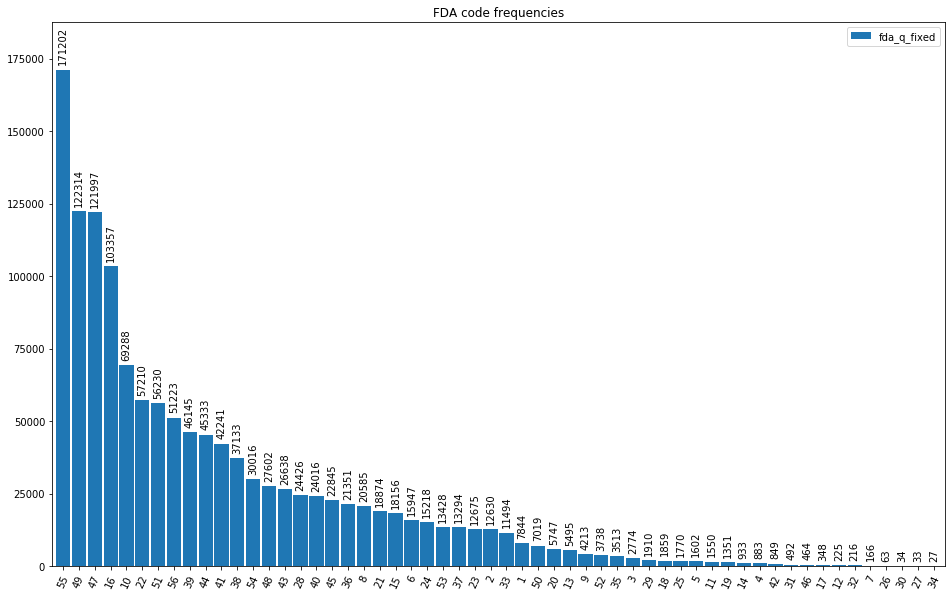

In [11]:
ph.plotValueCounts(df, 'fda_q_fixed', titleText='FDA code frequencies', saveAs='svg', ylim=[0.0, 187500.0])

***The class sizes span nearly 4 orders of magnitude!***

#### Word frequencies

In [12]:
t0 = time()
df['commentsWords'] = df['VIOCOMMENT'].apply(lambda s: s.split())
t1 = time()
Δt = t1 - t0
print(f"Δt: {Δt % 60.0:4.1f}s.")

Δt:  7.0s.


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [13]:
comments = list(df['commentsWords'])

##### Distribution of comment lengths

* Add length of each comment to DataFrame as `wordFreq` column

In [14]:
wordLens = [len(wordList) for wordList in comments]
df['wordFreq'] = wordLens
wordFreqMode = df['wordFreq'].mode().values[0]

wordCtSorted = sorted(wordLens)
print("smallest word counts:\n", wordCtSorted[:100])
print("largest word counts:\n", wordCtSorted[-101:-1])

smallest word counts:
 [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
largest word counts:
 [434, 434, 434, 440, 440, 440, 440, 440, 440, 441, 441, 442, 453, 454, 454, 458, 464, 464, 464, 464, 464, 464, 466, 466, 474, 474, 476, 476, 476, 480, 480, 481, 481, 481, 488, 498, 498, 498, 498, 503, 506, 506, 511, 511, 511, 533, 533, 534, 534, 535, 535, 536, 536, 536, 538, 538, 539, 542, 542, 542, 547, 552, 552, 553, 553, 564, 577, 577, 580, 580, 580, 580, 580, 580, 594, 594, 615, 615, 615, 619, 619, 619, 628, 628, 644, 644, 644, 649, 649, 670, 670, 670, 671, 671, 782, 782, 787, 787, 806, 806]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


**Detailed histogram**

Found  844 bins in data array.
Saving as  WordCountsHistWordCountsMax844Mode8.svg .
Δt:  3.39s.


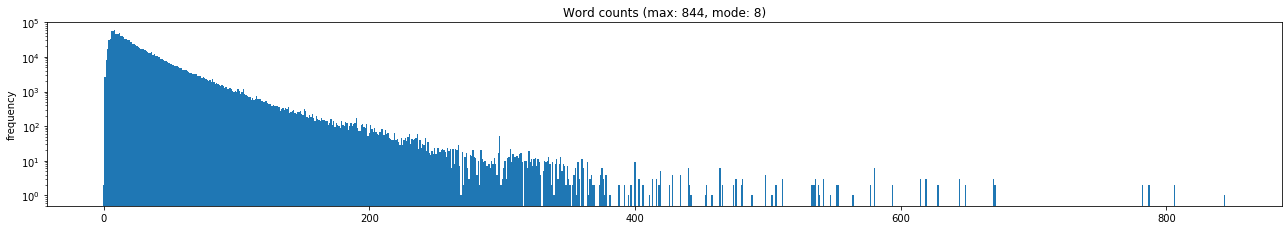

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(18, 3.5))

ph.detailedHistogram(wordLens, ylabel='frequency', volubility=2,
                     titleText=f"Word counts (max: {wordCtSorted[-1]}, mode: {wordFreqMode})",
                     figName="WordCountsHist", ax=ax, ylim = [0.5, 100000.0], ylog=True, saveAs='svg')

In [16]:
# fig, ax = plt.subplots(1, 1, figsize=(18, 3.5))
# ax.hist(wordLens, bins=np.linspace(0, 845, 846))
# ax.set_yscale('log')
# ax.set_ylim([0.5, 100000.0])
# ax.set_ylabel('freqency')
# plt.title(f"Word counts (max: {wordCtSorted[-1]}, mode: {wordFreqMode})")
# plt.tight_layout(rect=[0, 0.03, 1, 0.975])
# plt.savefig("WordCountsHist.svg")

**Make space**

In [17]:
del wordLens
del wordCtSorted
del df['commentsWords']

##### What FDA codes correspond to those comments having `wordFreq== 0`?

In [18]:
df[df['wordFreq']==0]
print("\n", df.shape)

,fda_q_fixed,VIOCOMMENT,FDAISCRITICAL,wordFreq
610833,49,,1,0
610835,49,,1,0



 (1307986, 4)


**Can safely remove a couple of records from the 2nd-most populated category**

* Originally there were 1307986 records in `df`, out of which 122314 were in Class 49

In [19]:
df = df[df['wordFreq']!=0]
df.shape

(1307984, 4)

##### `wordFreq` percentiles

* These show that would get 99% coverage of the comments without truncation if were to use, say, 140-element LSTMs

In [20]:
df.describe(percentiles=[0.01, 0.05, 0.15, 0.25, 0.5, 0.75, 0.85, 0.95, 0.99])

,fda_q_fixed,FDAISCRITICAL,wordFreq
count,1.307984e+06,1.307984e+06,1.307984e+06
mean,3.773048e+01,3.141223e-01,2.734516e+01
std,1.619211e+01,4.641656e-01,2.859241e+01
min,1.000000e+00,0.000000e+00,1.000000e+00
1%,2.000000e+00,0.000000e+00,3.000000e+00
5%,9.000000e+00,0.000000e+00,5.000000e+00
15%,1.600000e+01,0.000000e+00,7.000000e+00
25%,2.200000e+01,0.000000e+00,1.000000e+01
50%,4.400000e+01,0.000000e+00,1.800000e+01
75%,5.000000e+01,1.000000e+00,3.500000e+01


#### Most-common words

In [21]:
allWords = [word for wordList in comments for word in wordList]		# Flatten list of lists of words
print(len(comments), len(allWords))

print(comments[:5], "\n", allWords[:25])

1307986 35767027
[['Soap', 'and/or', 'paper', 'towels', 'are', 'not', 'provided', 'for', 'use', 'at', 'the', 'hand', 'wash', 'lavatory.', 'V/C'], ['Food', 'contact', 'surfaces', 'and', 'utensils', 'are', 'not', 'clean', 'to', 'sight', 'and', 'touch.', 'V/C'], ['An', 'accurate', 'product', 'temperature-measuring', 'device', 'is', 'not', 'provided.', 'V/C'], ['Bulk', 'containers', 'are', 'not', 'properly', 'labeled.', 'V/C'], ['Food', 'products', 'that', 'are', 'held', 'by', 'the', 'food', 'establishment', 'for', 'credit,', 'redemption', 'or', 'return', 'to', 'the', 'distributor', 'are', 'not', 'segregated', 'and', 'held', 'in', 'designated', 'areas', 'that', 'are', 'separated', 'from', 'food,', 'equipment,', 'utensils,', 'linens,', 'and', 'single', 'use', 'utensils/articles.', 'V/C']] 
 ['Soap', 'and/or', 'paper', 'towels', 'are', 'not', 'provided', 'for', 'use', 'at', 'the', 'hand', 'wash', 'lavatory.', 'V/C', 'Food', 'contact', 'surfaces', 'and', 'utensils', 'are', 'not', 'clean', 'to

In [22]:
t0 = time()
wordCtr = Counter(allWords)
t1 = time()
Δt = t1 - t0
print(f"Δt: {Δt % 60.0:4.1f}s.")

Δt:  5.8s.


##### Most common words, after removing stop words

*Result looks very plausible*

In [23]:
stopWords = text.ENGLISH_STOP_WORDS.union(['-'])

wcStops = [k for k in wordCtr if k.lower() in stopWords]
for k in wcStops:
    del wordCtr[k]
wordCtr.most_common(40)

[('food', 416195),
 ('Observed', 199727),
 ('stored', 190927),
 ('Basic', 172943),
 ('shall', 164416),
 ('sink', 135404),
 ('clean', 134875),
 ('cooler', 127169),
 ('equipment', 116502),
 ('surfaces', 101198),
 ('ice', 98110),
 ('properly', 92639),
 ('floor', 89994),
 ('area', 89722),
 ('water', 89455),
 ('Food', 88648),
 ('contact', 87364),
 ('used', 85530),
 ('hand', 85441),
 ('temperature', 83565),
 ('**Warning**', 83220),
 ('prep', 82074),
 ('time', 77755),
 ('observed', 77699),
 ('storage', 72918),
 ('utensils', 66834),
 ('employee', 65779),
 ('On-Site**', 65728),
 ('**Corrected', 65545),
 ('machine', 65157),
 ('use', 64437),
 ('area.', 62940),
 ('Clean', 62534),
 ('cold', 62019),
 ('inspection', 61344),
 ('Correction:', 60798),
 ('holding', 60728),
 ('good', 60532),
 ('line', 60306),
 ('items', 58171)]

#### Clean up

In [24]:
del allWords
del wordCtr

#### `fda_q_fixed` vs. `FDAISCRITICAL`

What is the relationship between the critical violation boolean and the FDA code?

In [25]:
dfCrit = df.groupby(['fda_q_fixed', 'FDAISCRITICAL']).count()
del dfCrit['VIOCOMMENT']
del dfCrit['wordFreq']
dfCrit.head(20)

dfCrit.reset_index(inplace=True)
dfCrit.head(20)

Empty DataFrame
Columns: []
Index: [(1, 0), (1, 1), (2, 0), (2, 1), (3, 0), (3, 1), (4, 0), (4, 1), (5, 0), (5, 1), (6, 0), (6, 1), (7, 1), (8, 0), (8, 1), (9, 0), (9, 1), (10, 0), (10, 1), (11, 0)]

,fda_q_fixed,FDAISCRITICAL
0,1,0
1,1,1
2,2,0
3,2,1
4,3,0
5,3,1
6,4,0
7,4,1
8,5,0
9,5,1


Text(0.5, 0.98, 'Critical violations vs FDA code')

(0.5, 56.5)

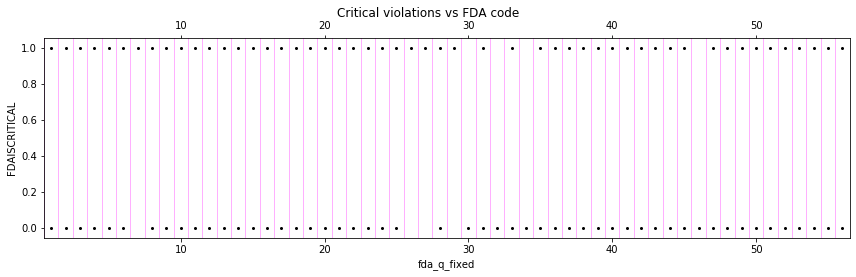

In [26]:
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.labeltop'] = True

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
dfCrit.plot.scatter('fda_q_fixed', 'FDAISCRITICAL', s=4, c='black', ax=ax)
for xv in np.linspace(0.5, 56.5, 57):
    _ = plt.axvline(x=xv, c="#FFB0FF", linewidth=1)
plt.suptitle('Critical violations vs FDA code')
ax.set_xlim([0.5, 56.5])
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.savefig('CriticalViolationVsFDAcode.svg')

**The critical violations plot shows that `FDAISCRITICAL` should be predictive (and certainly should be included in the model):**

* **<font color="darkgreen">classes 30, 32, 34 &amp; 46 *never* have critical violations</font>**
* **<font color="darkgreen">classes 7, 26, 27 &amp; 29 *only* have critical violations</font>**

## Pre-process data

* Here we use TF-IDF features to represent the comment text.

### Split DataFrame by classes

* create a `numpy.random.RandomState` instance to keep track of the random number initializer, in order to ensure consistent results throughout

`splitDataFrameByClasses()` will create two new DataFrames, dfTr, dfTe, according to the desired splits.

<font color='darkgreen'><b>Note that if you just want to do stratified sampling on a numpy array of</b> `X` <b>values,</b> `splitDataFramByClasses()` <b>is not needed.</b> `train_test_split()` <b>accepts the keyword</b> `stratify=myTargetVariable`.</b></font>

* Splitting is done on a per-class basis, so that random selection will not, by chance, yield huge imbalances in train-test splits of tiny classes

In [27]:
randomState=0
myRandomState = np.random.RandomState(randomState)

In [28]:
classColumn = 'fda_q_fixed'
dfTr, dfTe = util.splitDataFrameByClasses(df, classColumn,
                                          testFrac=0.50,
                                          myRandomState=myRandomState)
dfTr.shape, dfTe.shape
dfTr.head()
dfTe.head()

df.shape: (1307984, 4)
dfTrain.shape: (653979, 4)	dfTest.shape: (654005, 4)
Δt:  3.13s.


((653979, 4), (654005, 4))

,fda_q_fixed,VIOCOMMENT,FDAISCRITICAL,wordFreq
0,43,Ice scoop,0,2
1,16,Intermediate - Accumulation of black/green mol...,1,29
2,41,Basic - Wiping cloth quaternary ammonium compo...,0,25
3,9,3717-1-03.2(A)(2) - Critical - Preventing cont...,1,70
4,22,High Priority - Potentially hazardous (time/te...,1,48


,fda_q_fixed,VIOCOMMENT,FDAISCRITICAL,wordFreq
0,50,Hot and cold water available,0,5
1,22,High Priority - Potentially hazardous (time/te...,1,43
2,51,"Plumbing and sinks not properly sized, install...",0,14
3,22,3-501.16 (A)(2) and (B) Potentially Hazardous ...,1,77
4,49,Accumulation of food debris in condiment/bins ...,0,41


**As intended, `splitBalancedDataFrameClasses()` created a new train DataFrame with 10000 $\times$ 56 = 560000 rows, and a test DataFrame ~ 1307984/2 = 653992 rows.**

*The test DataFrame is not exactly an even split of the original, since the splitting is done by class and unioned.*

### TF-IDF

Let's compute TF-IDFs for each comment using scikit-learn's TF-IDF vectorizer.

* We'll use a logarithmic form: `sublinear_df=True`
* Ensure Euclidian norms for each vecture: `norm='l2'`
* Include bigrams, as well as unigrams: `ngram_range=(1,2)`
* English stop words: `stop_words='english'`
* toss very infrequent terms (appearing in fewer than 5 comments): `min_df=5`

#### Fit TF-IDF  features; transform train set (~40 seconds)

In [29]:
dfTe[['FDAISCRITICAL']].head(16).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
FDAISCRITICAL,0,1,0,1,0,1,1,0,0,1,0,0,0,1,0,1


In [30]:
t0 = time()
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2',
                        encoding='latin-1', ngram_range=(1, 2),
                        stop_words='english')
Xtr = tfidf.fit_transform(dfTr.VIOCOMMENT)
Xtr.shape
yTr = dfTr.fda_q_fixed
t1 = time()
Δt = t1 - t0
print(f"Δt: {Δt % 60.0:4.1f}s.")

(653979, 196226)

Δt: 38.6s.


**Xtr has 653979 ~ 653992 = 1307984 / 2 rows and ~196k columns. The latter represent the ~196k features in the training set unigram and bigram 'vocabulary'**

In [31]:
type(Xtr)
for i, row in enumerate(Xtr):
    if i > 1:
        break
    print(i, "\n", row)
    i += 1

scipy.sparse.csr.csr_matrix

0 
   (0, 91896)	0.6832394038255261
  (0, 154925)	0.6104995988021777
  (0, 91508)	0.40059225769168316
1 
   (0, 189723)	0.1472749126163781
  (0, 145999)	0.11548839598200744
  (0, 168471)	0.2268115224378171
  (0, 190069)	0.2224199658276119
  (0, 23006)	0.309224884491468
  (0, 91554)	0.16550382963821567
  (0, 99281)	0.23287228529711496
  (0, 107606)	0.21843628520637703
  (0, 107569)	0.20238301501071881
  (0, 91778)	0.20669465233347362
  (0, 96327)	0.17294124703175695
  (0, 172086)	0.18999367107146517
  (0, 103778)	0.1511494421920414
  (0, 114948)	0.1440677735582097
  (0, 83680)	0.17259589175995022
  (0, 23263)	0.17253876347730002
  (0, 12716)	0.16670776785761773
  (0, 96491)	0.16002210375814838
  (0, 191534)	0.10045758391008361
  (0, 189367)	0.09237965684639488
  (0, 145765)	0.10474711526943936
  (0, 168017)	0.11906522640061684
  (0, 190058)	0.2059142336817157
  (0, 22786)	0.1505825045928079
  (0, 99006)	0.10818992490209459
  (0, 107117)	0.1659882658042639
  (0, 96214)	0.1314944349473753

#### Transform test set (~35 seconds)

In [32]:
t0 = time()
Xte = tfidf.transform(dfTe.VIOCOMMENT)
Xte.shape
yTe = dfTe.fda_q_fixed
t1 = time()
Δt = t1 - t0
print(f"Δt: {Δt % 60.0:4.1f}s.")

(654005, 196226)

Δt: 36.8s.


**same number of columns for Xte, as for Xtr.**

#### Sanity check: show features most correlated with classes

* Figure out which of 196k features are most correlated with each of the FDA codes (~1 minute, 10 seconds)

In [33]:
t0 = time()
N = 5

FDAcodes = sorted(list(set(df.fda_q_fixed)))

for FDAcode in FDAcodes:
    Xχ2 = chi2(Xtr, yTr==FDAcode)
    indices = np.argsort(Xχ2[0])
    featureNames = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in featureNames if len(v.split(' ')) == 1]
    bigrams = [v for v in featureNames if len(v.split(' ')) == 2]
    print(f"\nFCA code {FDAcode:02d}:")
    print("Most correlated unigrams::\t{{{}".format('}  {'.join(unigrams[-N:])), end='}')
    print("\nMost correlated bigrams::\t{{{}".format('}  {'.join(bigrams[-N:])), end='}')
t1 = time()
Δt = t1 - t0
print(f"\n\nΔt: {int(Δt//60)}m, {Δt % 60.0:4.1f}s.")


FCA code 01:
Most correlated unigrams::	{demonstrate}  {duties}  {violations}  {knowledge}  {demonstration}
Most correlated bigrams::	{11 demonstration}  {demonstration priority}  {knowledge food}  {priority violations}  {demonstration knowledge}
FCA code 02:
Most correlated unigrams::	{http}  {accredited}  {certificate}  {certification}  {certified}
Most correlated bigrams::	{protection manager}  {food safety}  {manager certification}  {food manager}  {certified food}
FCA code 03:
Most correlated unigrams::	{illnesses}  {conditional}  {policy}  {reporting}  {symptoms}
Most correlated bigrams::	{employees informed}  {responsibility report}  {conditional employees}  {health policy}  {employee health}
FCA code 04:
Most correlated unigrams::	{infections}  {wound}  {ill}  {reinstatements}  {exclusions}
Most correlated bigrams::	{ill employees}  {records exclusions}  {employees maintained}  {maintained operator}  {exclusions restrictions}
FCA code 05:
Most correlated unigrams::	{fecal}  {r

#### Add `FDAISCRITICAL` column vales to `Xtr` and `Xte`

In [34]:
Xtrp = sp.hstack([Xtr, sp.csr_matrix(dfTr[['FDAISCRITICAL']])], 'csr')
np.shape(Xtrp)

(653979, 196227)

In [35]:
Xtep = sp.hstack([Xte, sp.csr_matrix(dfTe[['FDAISCRITICAL']])], 'csr')
np.shape(Xtep)

(654005, 196227)

In [36]:
del Xtr
del Xte

### Do some garbage collection before building models

In [37]:
for i in range(2):
    print('\nCollecting {} ...'.format(i))
    n = gc.collect()
    print('Unreachable objects:', n)
    print('Remaining Garbage:', end=' ')
    pprint.pprint(gc.garbage)


Unreachable objects: 67993
Remaining Garbage: []

Unreachable objects: 0
Remaining Garbage: []


## Models

### Logistic Regression

#### TF-IDF with `FDAISCRITICAL`

* Run defaults for now, except `class_weight='balanced'`
* `n_jobs=7` means use 8 processors (as it is set to $n_{\mathrm{threads}} - 1$)
* For np.shape(Xtrp) = (560000, 196227), fit takes ~30 min.

In [38]:
np.shape(Xtrp), np.shape(yTr), np.shape(Xtep), np.shape(yTe)

((653979, 196227), (653979,), (654005, 196227), (654005,))

In [39]:
print(asctime(gmtime()))
LRname = 'LogisticRegressor0.joblib'

if os.path.isfile(LRname):
    LR = load(LRname)
    t1 = time()
else:
    CV = 5
    LR = LogisticRegression(random_state=myRandomState, n_jobs=7,
                            solver='newton-cg', class_weight='balanced')
    t0 = time()
    LR.fit(Xtrp, yTr)
    t1 = time()
    Δt01 = t1 - t0
    print("Δt01: {0} m, {1:4.1f} s.".format(int(Δt01//60), Δt01 % 60.0))

yPred = LR.predict(Xtep)
t2 = time()
Δt12 = t2 - t1
print("Δt12: {0} m, {1:4.1f} s.".format(int(Δt12//60), Δt12 % 60.0))

Mon Aug 19 00:59:29 2019


/home/wilber/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=7, penalty='l2',
                   random_state=<mtrand.RandomState object at 0x7fabb5f97f00>,
                   solver='newton-cg', tol=0.0001, verbose=0, warm_start=False)

Δt01: 32 m, 52.2 s.
Δt12: 0 m,  2.4 s.


In [40]:
print(yTe[:20].values)
print(yPred[:20])

[50 22 51 22 49 16 28 44 51 16 45 55 55 16 48 21 38 33 38 55]
[50 22 51 22 49 16 28 39 51 16 39 55 55 16 48 21 38 33 38 49]


**Save model to disk**

In [41]:
if not os.path.isfile(LRname):
    dump(LR, LRname)

['LogisticRegressor0.joblib']

#### Overall accuracy, precision, recall

In [42]:
confusionMat = confusion_matrix(yTe, yPred)
print(confusionMat)

[[ 2939   396   264 ...     0     0     0]
 [  372  5831    43 ...     0     0     0]
 [   92    55  1172 ...     0     0     0]
 ...
 [    6     0     0 ... 13829   306    53]
 [    5     4     0 ...   475 69388  2268]
 [    1     1     0 ...    55  1313 21168]]


In [43]:
accuracy = np.trace(confusionMat)/np.sum(confusionMat)
recall = np.diag(confusionMat)/np.sum(confusionMat, axis=1)
precision = np.diag(confusionMat)/np.sum(confusionMat, axis=0)
print(f"accuracy: {accuracy:0.3f}, "
      f"<precision>: {np.mean(precision):0.3f}, "
      f"<recall>: {np.mean(recall):0.3f}")

accuracy: 0.864, <precision>: 0.798, <recall>: 0.806


##### Recall, precision by class

Note:

* `macro avg`: $\frac{1}{K}\sum_k m_k$, where $K$ is count of classes and $m_k$ is a given metric for class $k$
* `weighted avg`: $\frac{1}{N}\sum_k n_k \cdot m_k$, where $N$ is count of data instance, $n_k$ is the count of points in class $k$ and $m_k$ is a given metric for class $k$.

In [44]:
print(metrics.classification_report(yTe.values, yPred, target_names=[str(c)for c in FDAcodes]))

              precision    recall  f1-score   support

           1       0.81      0.75      0.78      3922
           2       0.90      0.92      0.91      6315
           3       0.72      0.84      0.78      1387
           4       0.70      0.52      0.60       442
           5       0.88      0.95      0.92       801
           6       0.93      0.94      0.93      7974
           7       0.63      0.77      0.70        83
           8       0.88      0.90      0.89     10293
           9       0.86      0.88      0.87      2107
          10       0.97      0.97      0.97     34644
          11       0.69      0.57      0.62       775
          12       0.70      0.45      0.55       113
          13       0.80      0.79      0.79      2748
          14       0.87      0.87      0.87       467
          15       0.90      0.87      0.88      9078
          16       0.96      0.96      0.96     51679
          17       0.66      0.52      0.58       174
          18       0.83    

In [45]:
classCts = dfTe['fda_q_fixed'].value_counts()

recall = np.diag(confusionMat)/np.sum(confusionMat, axis = 1)
precision = np.diag(confusionMat)/np.sum(confusionMat, axis = 0)
f1 = 2.0*precision*recall/(precision + recall)
print("class\tprecision\trecall\tf1\tsize")

for FDAcode, classCt in classCts.iteritems():
    print(f"{FDAcode}\t{precision[FDAcode - 1]:0.3f}\t\t{recall[FDAcode - 1]:0.3f}\t{f1[FDAcode - 1]:0.3f}\t\t{classCt:d}")

class	precision	recall	f1	size
55	0.872		0.811	0.840		85601
49	0.797		0.812	0.805		61156
47	0.828		0.763	0.794		60999
16	0.957		0.963	0.960		51679
10	0.967		0.973	0.970		34644
22	0.896		0.874	0.885		28605
51	0.844		0.879	0.861		28115
56	0.817		0.826	0.822		25612
39	0.833		0.843	0.838		23073
44	0.845		0.803	0.823		22667
41	0.912		0.944	0.928		21121
38	0.910		0.939	0.924		18567
54	0.921		0.921	0.921		15008
48	0.812		0.839	0.825		13801
43	0.818		0.880	0.848		13319
28	0.941		0.946	0.944		12213
40	0.956		0.956	0.956		12008
45	0.779		0.853	0.814		11423
36	0.879		0.937	0.907		10676
8	0.880		0.896	0.888		10293
21	0.785		0.803	0.794		9437
15	0.896		0.871	0.884		9078
6	0.929		0.936	0.932		7974
24	0.869		0.911	0.889		7609
53	0.723		0.869	0.789		6714
37	0.904		0.916	0.910		6647
23	0.888		0.906	0.897		6338
2	0.899		0.923	0.911		6315
33	0.787		0.910	0.844		5747
1	0.808		0.749	0.778		3922
50	0.773		0.912	0.837		3510
20	0.814		0.872	0.842		2874
13	0.805		0.785	0.795		2748
9	0.856		0.878	0.867		2107
52

##### Plot confusion matrix

* As this is a straight confusion matrix, diagonal elements mostly reflect class size in test set
* *This is hard to interpret by visual inspection alone*

In [46]:
labelFontSz = 16
tickFontSz = 13
titleFontSz = 20

Δt: 11.34s.


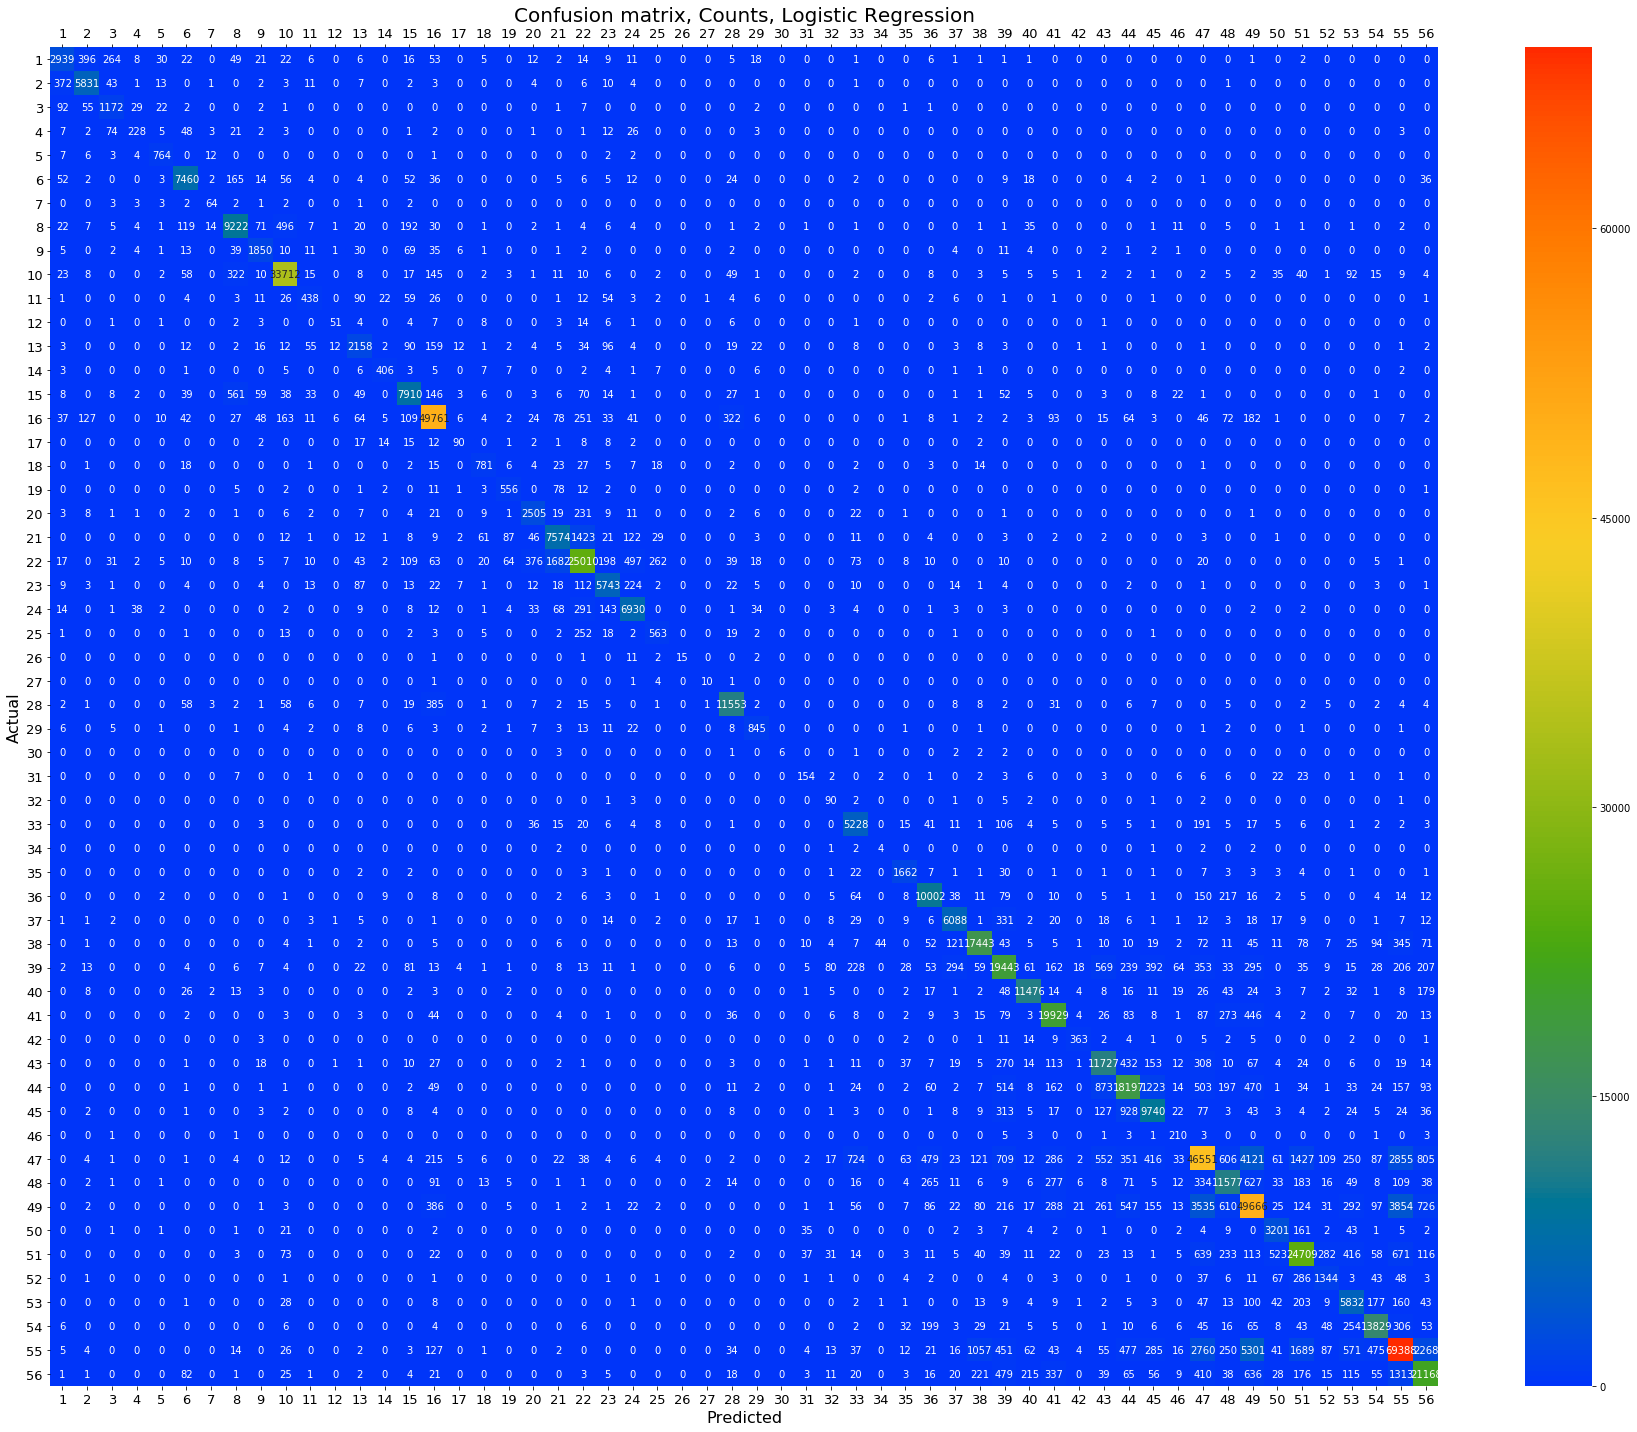

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(25, 25))
ph.plotConfusionMatrix(confusionMat, saveAs='pdf', xlabels=FDAcodes,
                       ylabels=FDAcodes, titleText = 'Logistic Regression',
                       ax = ax,  xlabelFontSz=labelFontSz,
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

##### Plot recall confusion matrix (normalized by row)

* diagonal elements now represent the *recall* for each class

Δt: 12.41s.


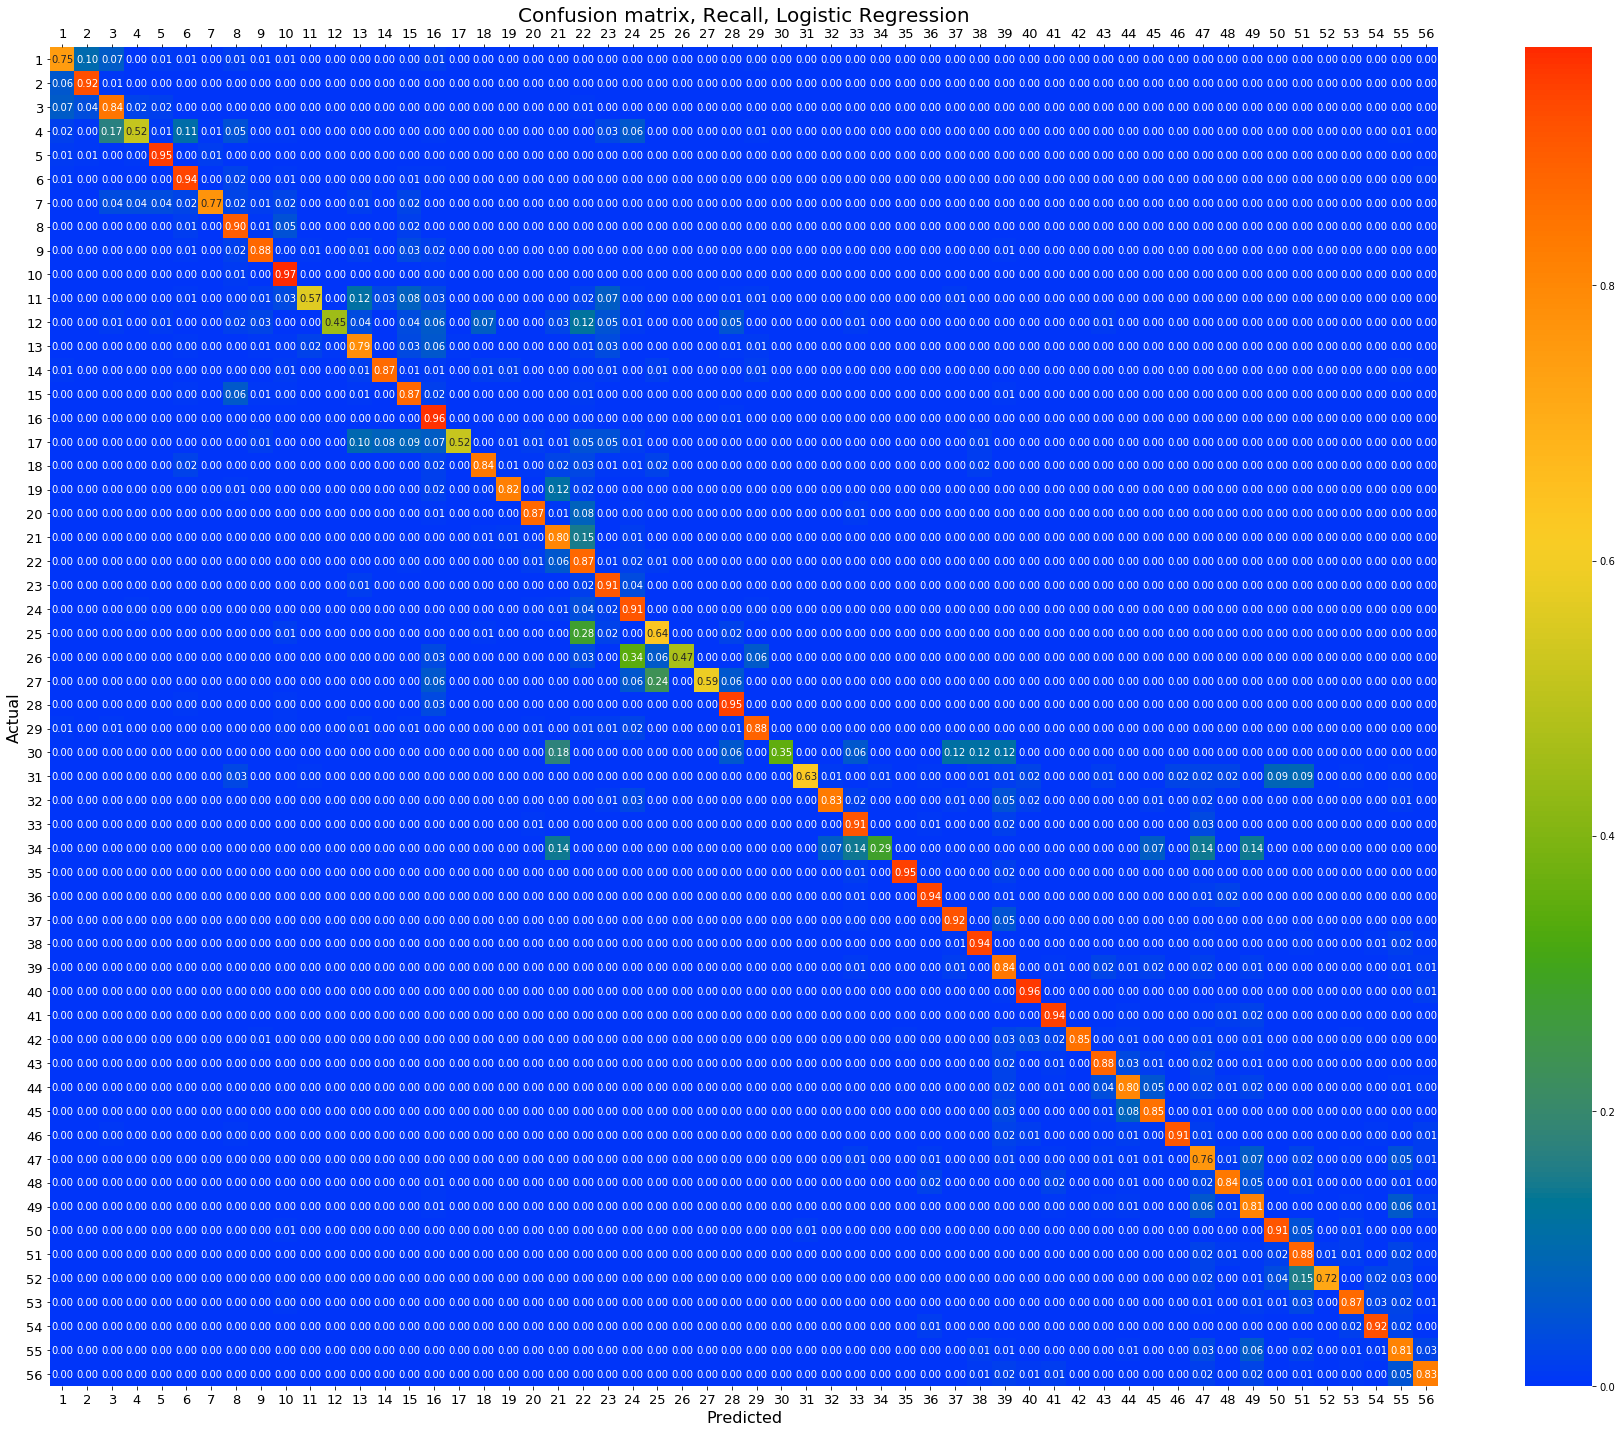

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(25, 25))
ph.plotConfusionMatrix(confusionMat, saveAs='pdf', xlabels=FDAcodes, type='recall',
                       ylabels=FDAcodes, titleText = 'Logistic Regression',
                       ax = ax,  xlabelFontSz=labelFontSz,
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

##### Plot precision confusion matrix (normalized by column)

* diagonal elements now represent the *precision* for each class

Δt: 11.55s.


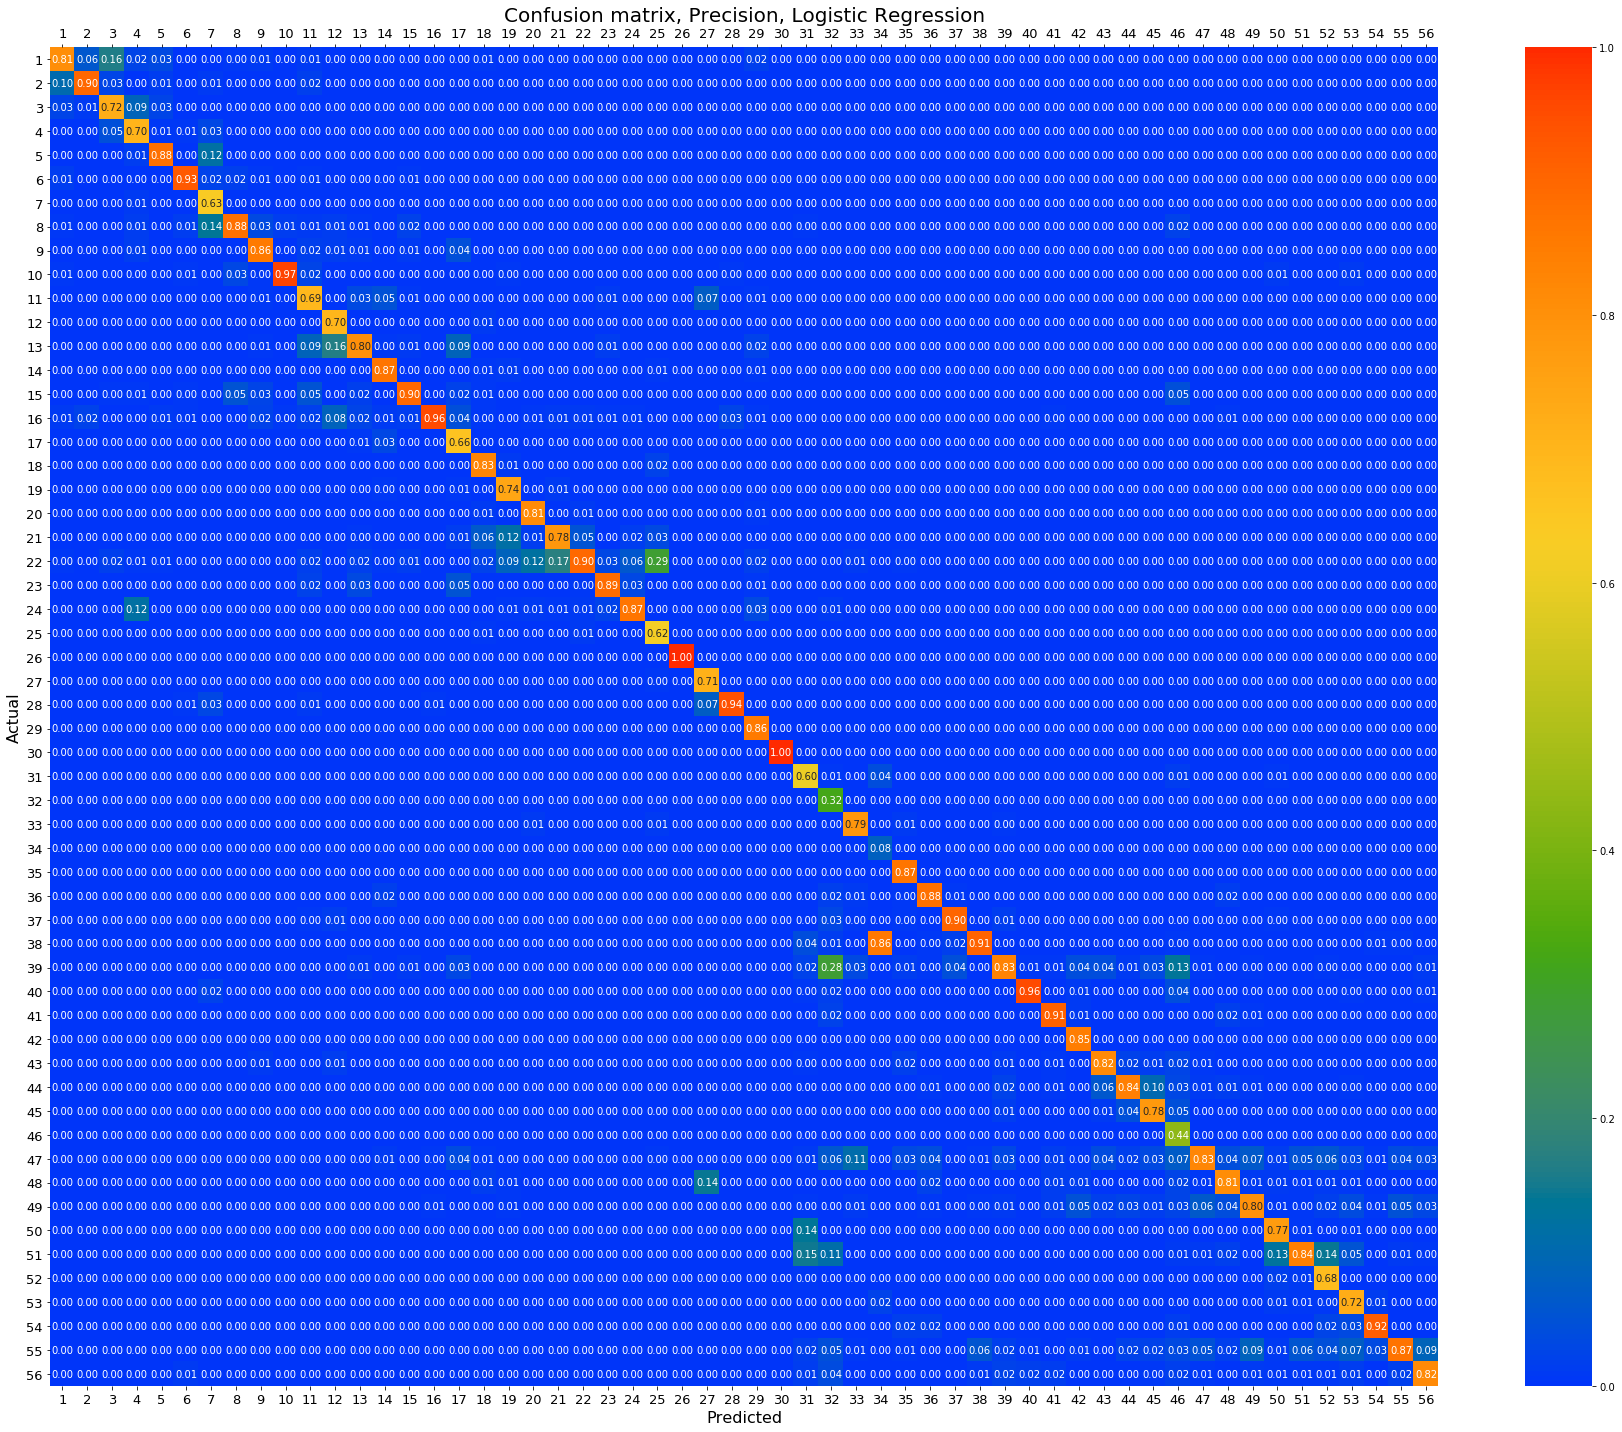

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(25, 25))
ph.plotConfusionMatrix(confusionMat, saveAs='pdf', xlabels=FDAcodes, type='precision',
                       ylabels=FDAcodes, titleText = 'Logistic Regression',
                       ax = ax,  xlabelFontSz=labelFontSz,
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

In [50]:
del LR

#### Do some garbage collection before building RF models

In [52]:
for i in range(2):
    print('\nCollecting {} ...'.format(i))
    n = gc.collect()
    print('Unreachable objects:', n)
    print('Remaining Garbage:', end=' ')
    pprint.pprint(gc.garbage)


Unreachable objects: 20
Remaining Garbage: []

Unreachable objects: 0
Remaining Garbage: []


### Random Forest

#### TF-IDF with `FDAISCRITICAL`, `max_depth=250`

* Run defaults for now, except `n_estimators=160` (default is 10)
* For np.shape(Xtr) = (560000, 178558), fit takes ~150 min.

<font color='darkred'>***The very long training time in this instance is due to memory swapping.
(Fortunately, on my 12 GB machine, the swap space is on a flash drive.)
Reducing the `max_depth` from 250 should help to reduce the memory requirements.***</font>

In [53]:
np.shape(Xtrp), np.shape(yTr), np.shape(Xtep), np.shape(yTe)

((653979, 196227), (653979,), (654005, 196227), (654005,))

In [54]:
print(asctime(gmtime()))
RFname = 'RandomForest0.joblib'

if os.path.isfile(RFname):
    RF = load(RFname)
    t1 = time()
else:
    RF = RandomForestClassifier(random_state=myRandomState, n_jobs=7, n_estimators=160,
                                max_depth=250, class_weight='balanced')
    t0 = time()
    RF.fit(Xtrp, yTr)
    t1 = time()
    Δt01 = t1 - t0
    print("Δt01: {0} m, {1:4.1f} s.".format(int(Δt01//60), Δt01 % 60.0))

yPred = RF.predict(Xtep)
t2 = time()
Δt12 = t2 - t1
print("Δt12: {0} m, {1:4.1f} s.".format(int(Δt12//60), Δt12 % 60.0))

Mon Aug 19 03:08:22 2019


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=250, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=160, n_jobs=7, oob_score=False,
                       random_state=<mtrand.RandomState object at 0x7fabb5f97f00>,
                       verbose=0, warm_start=False)

Δt01: 197 m,  1.6 s.
Δt12: 3 m, 45.9 s.


In [55]:
print(yTe[:20].values)
print(yPred[:20])

[50 22 51 22 49 16 28 44 51 16 45 55 55 16 48 21 38 33 38 55]
[50 22 51 22 49 16 28 44 51 16 39 55 55 16 48 21 38 33 38 55]


**Save model to disk**

<font color="darkred">Nope. Not agonna do this; model is yuge &mdash; 15 GB!</font>

In [56]:
# if not os.path.isfile(RFname):
#     dump(RF, RFname)

#### Overall accuracy, precision, recall

In [57]:
confusionMat = confusion_matrix(yTe, yPred)
print(confusionMat)

[[ 3113   353   147 ...     1     2     3]
 [  255  5940    44 ...     0     1     0]
 [   57    33  1228 ...     0     1     2]
 ...
 [    2     0     0 ... 14079   229    43]
 [    2    11     0 ...   331 75225  1721]
 [    1     2     0 ...    44  1023 22167]]


In [58]:
accuracy = np.trace(confusionMat)/np.sum(confusionMat)
recall = np.diag(confusionMat)/np.sum(confusionMat, axis=1)
precision = np.diag(confusionMat)/np.sum(confusionMat, axis=0)
print(f"accuracy: {accuracy:0.3f}, "
      f"<precision>: {np.mean(precision):0.3f}, "
      f"<recall>: {np.mean(recall):0.3f}")

accuracy: 0.893, <precision>: 0.813, <recall>: 0.810


##### Recall, precision by class

In [59]:
print(metrics.classification_report(yTe.values, yPred, target_names=[str(c)for c in FDAcodes]))

              precision    recall  f1-score   support

           1       0.87      0.79      0.83      3922
           2       0.91      0.94      0.92      6315
           3       0.82      0.89      0.85      1387
           4       0.63      0.65      0.64       442
           5       0.91      0.93      0.92       801
           6       0.91      0.92      0.92      7974
           7       0.56      0.83      0.67        83
           8       0.90      0.91      0.90     10293
           9       0.90      0.86      0.88      2107
          10       0.94      0.98      0.96     34644
          11       0.60      0.64      0.62       775
          12       0.59      0.46      0.52       113
          13       0.78      0.79      0.79      2748
          14       0.87      0.88      0.87       467
          15       0.92      0.88      0.90      9078
          16       0.94      0.95      0.94     51679
          17       0.79      0.60      0.68       174
          18       0.82    

In [60]:
classCts = dfTe['fda_q_fixed'].value_counts()

recall = np.diag(confusionMat)/np.sum(confusionMat, axis = 1)
precision = np.diag(confusionMat)/np.sum(confusionMat, axis = 0)
f1 = 2.0*precision*recall/(precision + recall)
print("class\tprecision\trecall\tf1\tsize")

for FDAcode, classCt in classCts.iteritems():
    print(f"{FDAcode}\t{precision[FDAcode - 1]:0.3f}\t\t{recall[FDAcode - 1]:0.3f}\t{f1[FDAcode - 1]:0.3f}\t\t{classCt:d}")

class	precision	recall	f1	size
55	0.896		0.879	0.887		85601
49	0.867		0.857	0.862		61156
47	0.879		0.831	0.854		60999
16	0.938		0.949	0.944		51679
10	0.938		0.977	0.957		34644
22	0.896		0.918	0.907		28605
51	0.875		0.917	0.896		28115
56	0.868		0.865	0.867		25612
39	0.871		0.868	0.869		23073
44	0.919		0.834	0.874		22667
41	0.928		0.937	0.932		21121
38	0.921		0.947	0.934		18567
54	0.929		0.938	0.934		15008
48	0.888		0.866	0.877		13801
43	0.853		0.916	0.883		13319
28	0.954		0.937	0.945		12213
40	0.949		0.953	0.951		12008
45	0.819		0.905	0.860		11423
36	0.888		0.954	0.920		10676
8	0.896		0.910	0.903		10293
21	0.839		0.869	0.854		9437
15	0.917		0.875	0.896		9078
6	0.914		0.922	0.918		7974
24	0.914		0.877	0.895		7609
53	0.830		0.852	0.841		6714
37	0.882		0.921	0.902		6647
23	0.904		0.921	0.913		6338
2	0.908		0.941	0.924		6315
33	0.913		0.855	0.883		5747
1	0.866		0.794	0.828		3922
50	0.819		0.899	0.857		3510
20	0.891		0.850	0.870		2874
13	0.783		0.789	0.786		2748
9	0.905		0.864	0.884		2107
52

##### Plot confusion matrix

* As this is a straight confusion matrix, diagonal elements mostly reflect class size in test set
* *This is hard to interpret by visual inspection alone*

In [61]:
labelFontSz = 16
tickFontSz = 13
titleFontSz = 20

Δt: 12.37s.


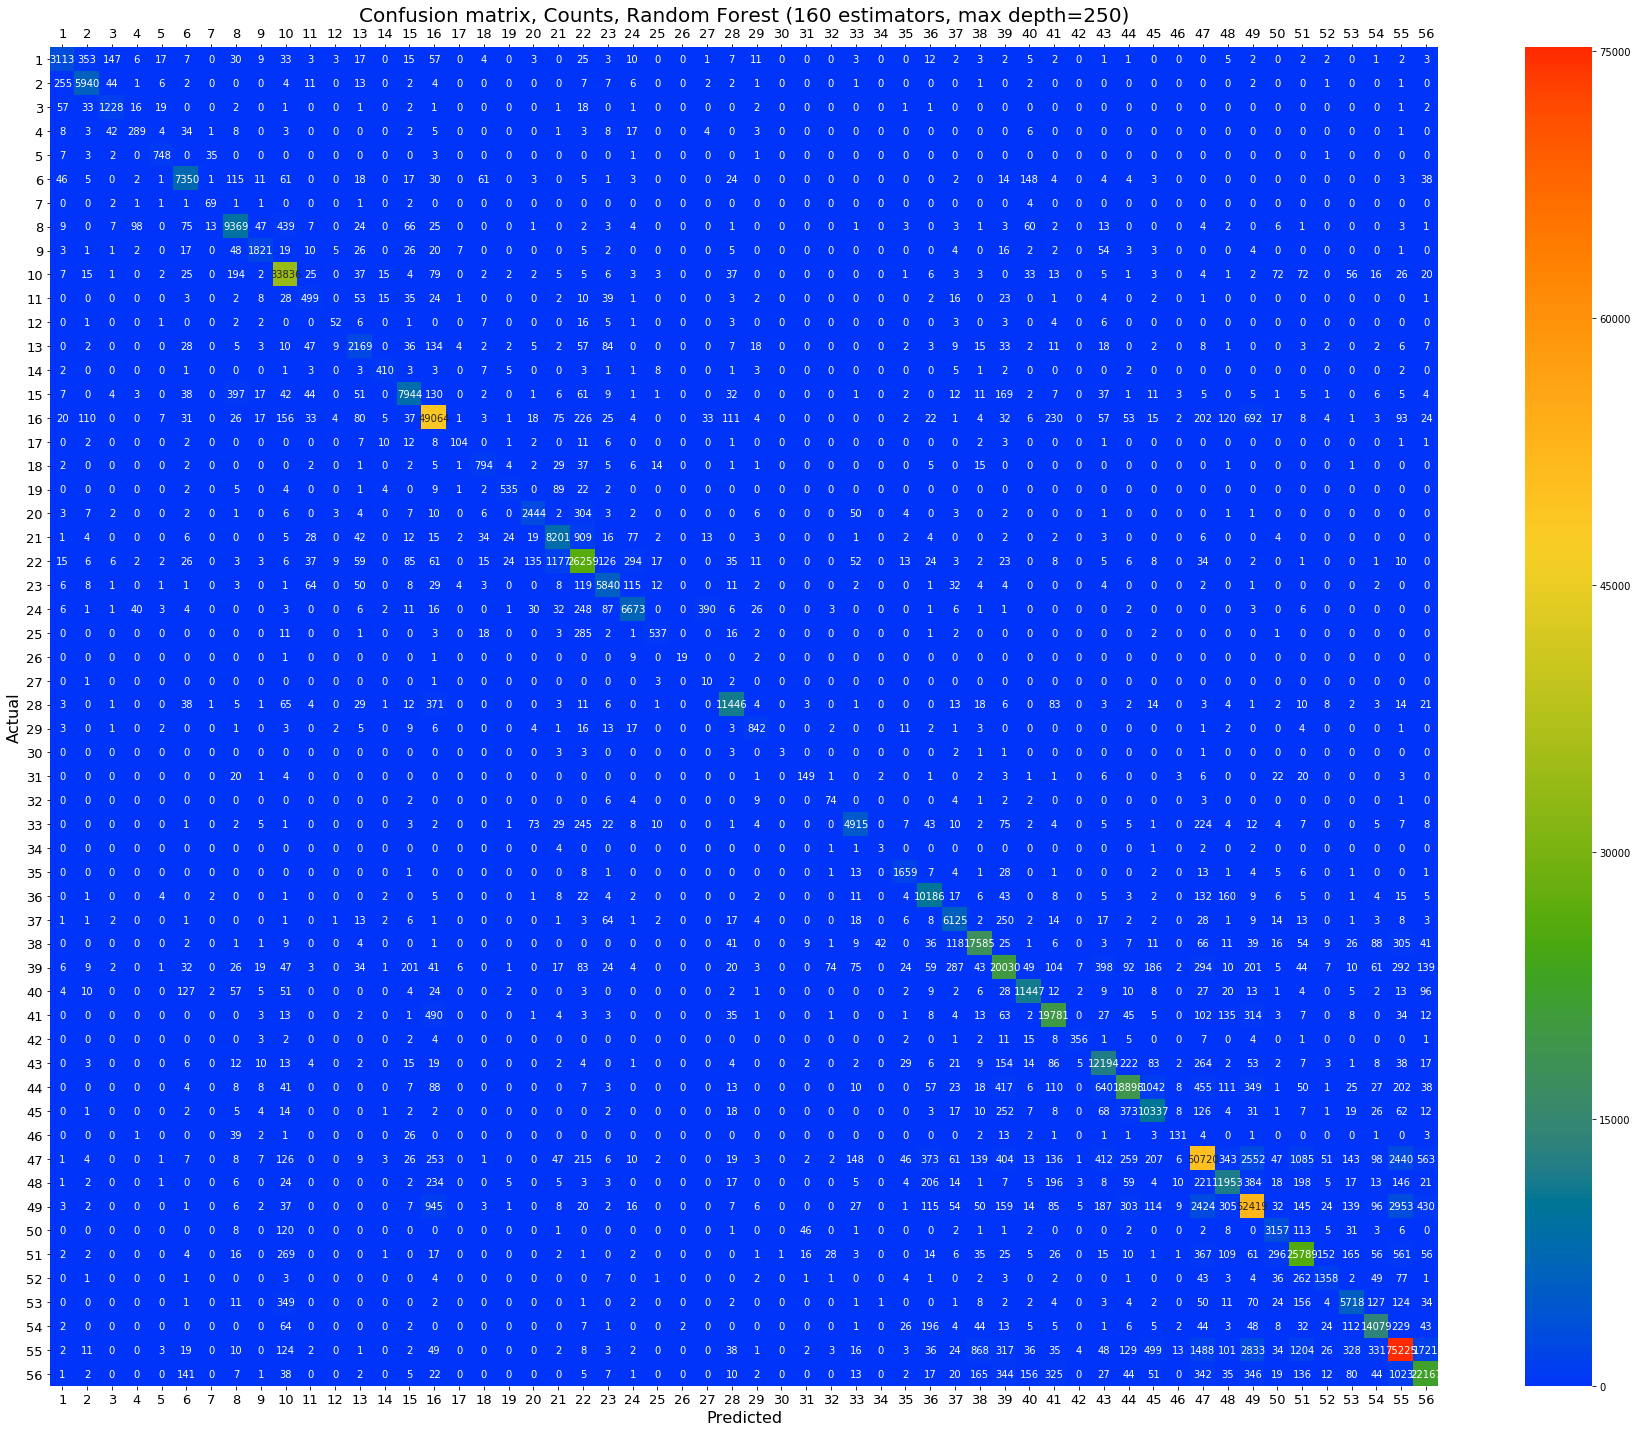

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(25, 25))
ph.plotConfusionMatrix(confusionMat, saveAs='pdf', xlabels=FDAcodes,
                       ylabels=FDAcodes, titleText = 'Random Forest (160 estimators, max depth=250)',
                       ax = ax,  xlabelFontSz=labelFontSz,
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

##### Plot recall confusion matrix (normalized by row)

* diagonal elements now represent the *recall* for each class

Δt: 11.97s.


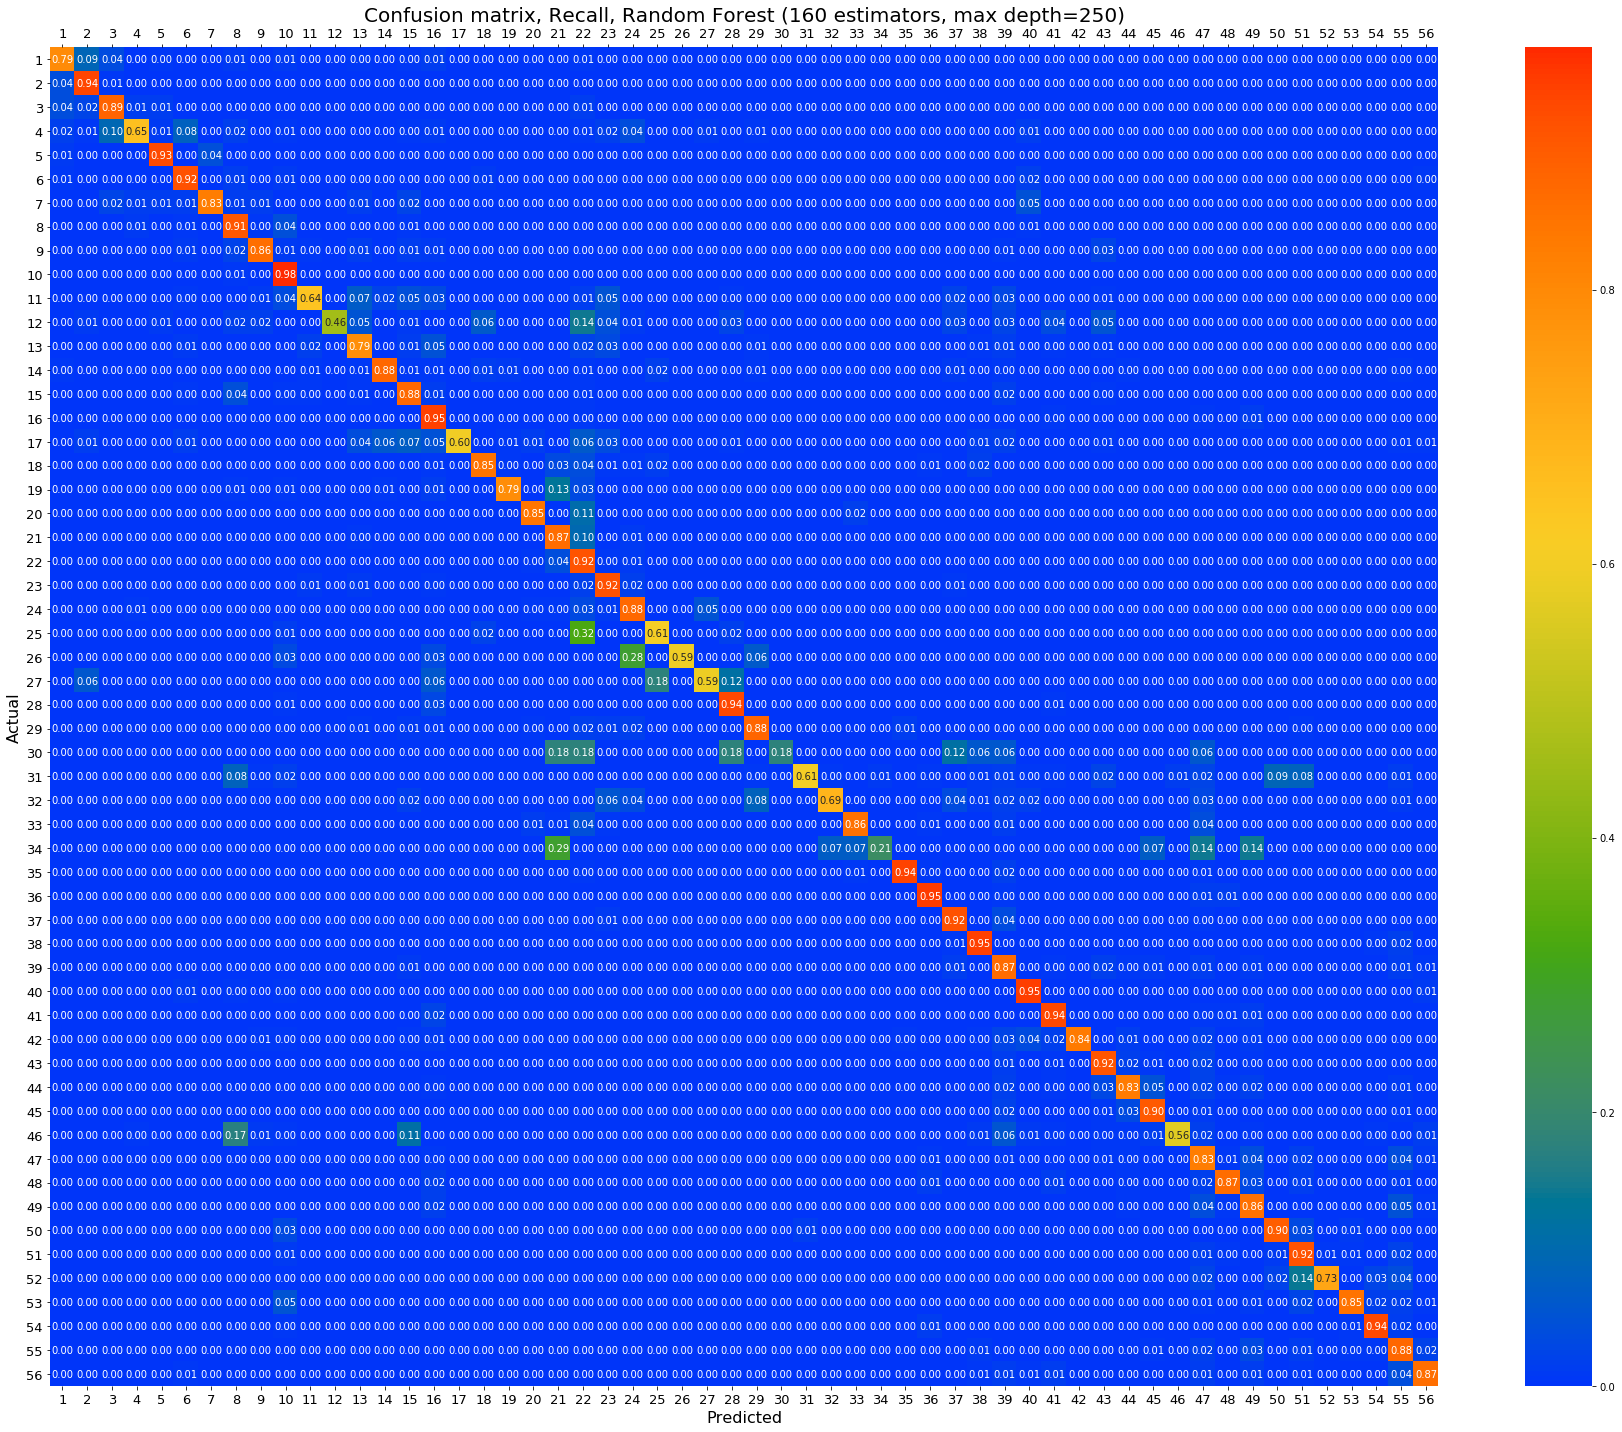

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(25, 25))
ph.plotConfusionMatrix(confusionMat, saveAs='pdf', xlabels=FDAcodes, type='recall',
                       ylabels=FDAcodes, titleText = 'Random Forest (160 estimators, max depth=250)',
                       ax = ax,  xlabelFontSz=labelFontSz,
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

##### Plot precision confusion matrix (normalized by column)

* diagonal elements now represent the *precision* for each class

Δt: 57.10s.


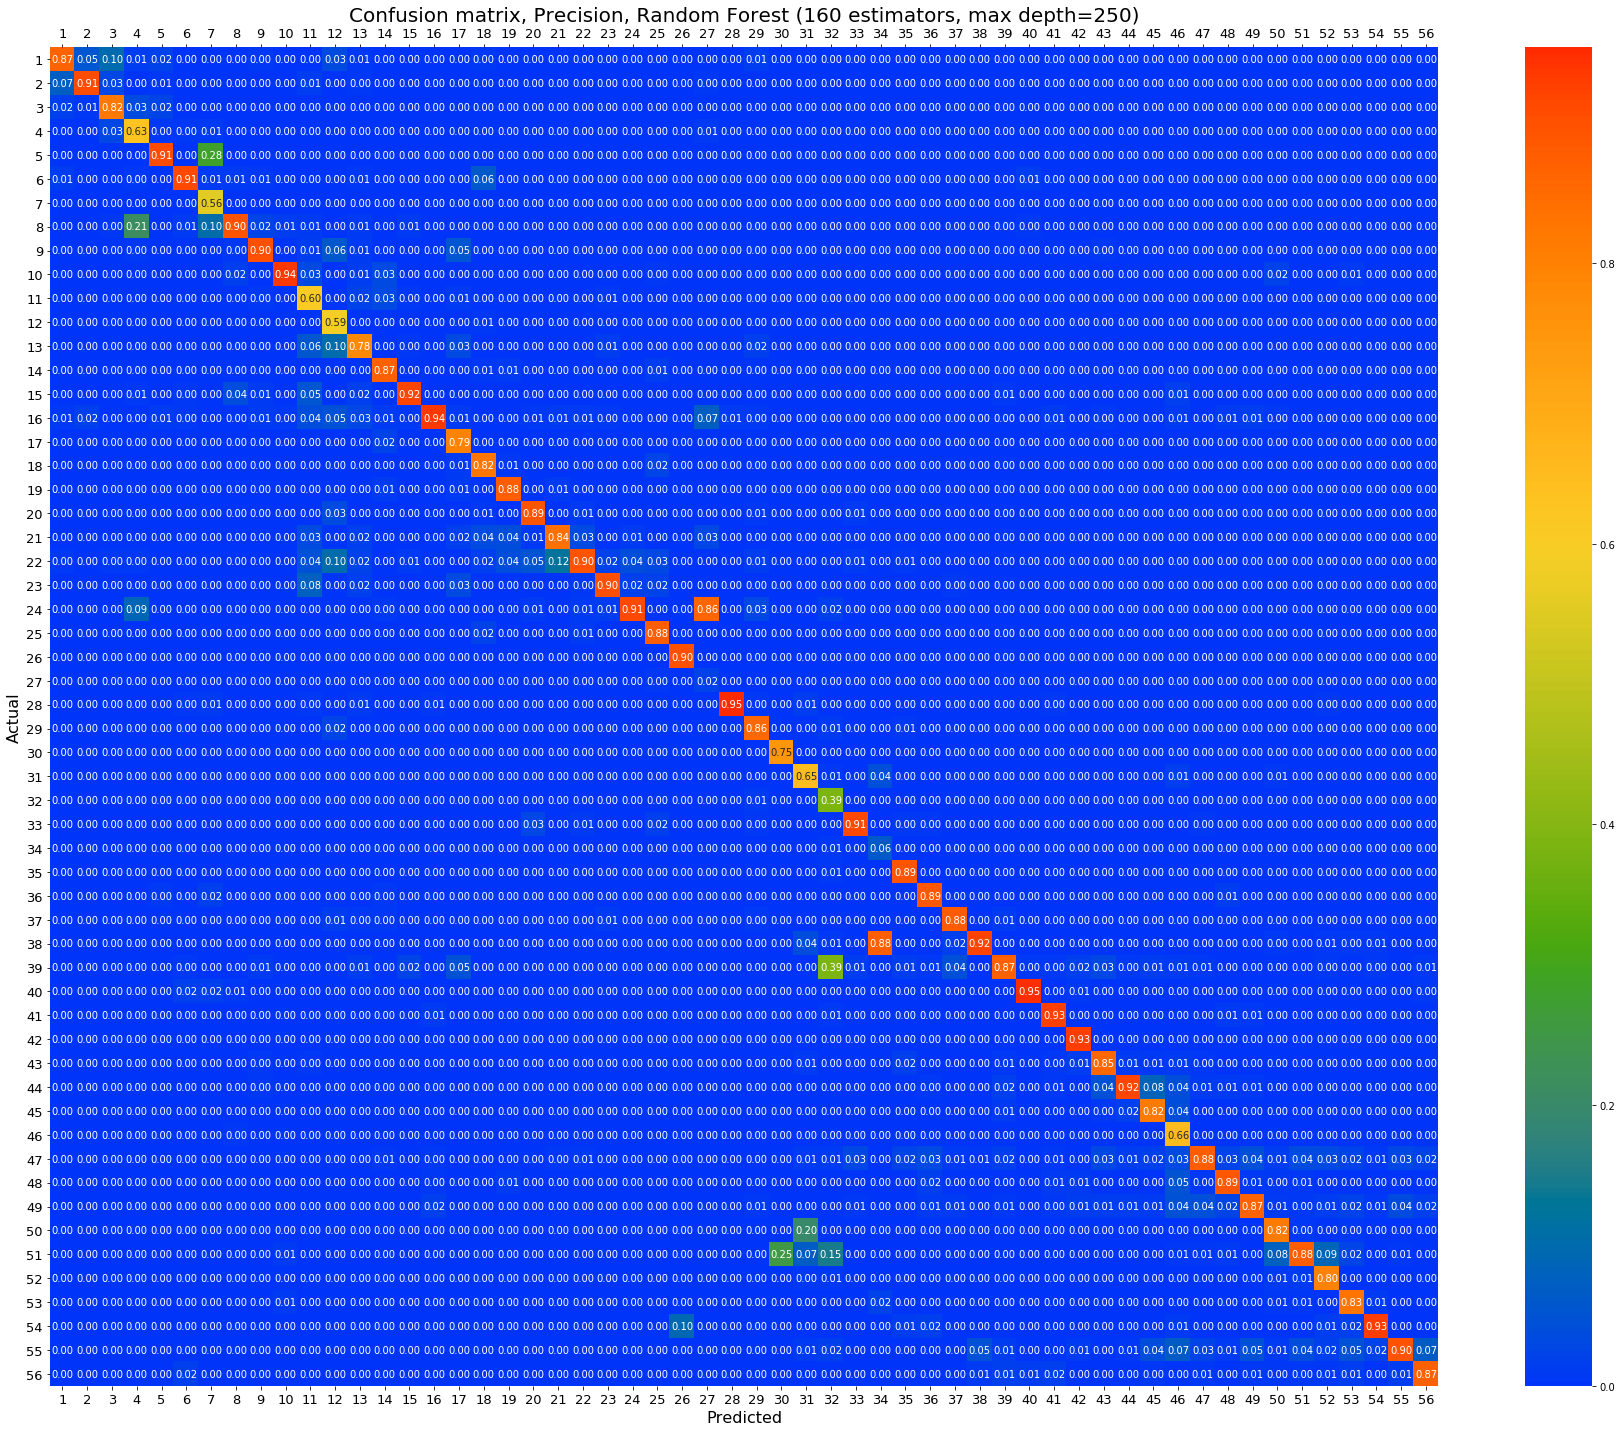

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(25, 25))
ph.plotConfusionMatrix(confusionMat, saveAs='pdf', xlabels=FDAcodes, type='precision',
                       ylabels=FDAcodes, titleText = 'Random Forest (160 estimators, max depth=250)',
                       ax = ax,  xlabelFontSz=labelFontSz,
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

In [67]:
del RF

#### Do some garbage collection before building RF models

In [68]:
for i in range(2):
    print('\nCollecting {} ...'.format(i))
    n = gc.collect()
    print('Unreachable objects:', n)
    print('Remaining Garbage:', end=' ')
    pprint.pprint(gc.garbage)


Unreachable objects: 40
Remaining Garbage: []

Unreachable objects: 0
Remaining Garbage: []


### LinearSVC

#### TF-IDF with `FDAISCRITICAL`

* `penalty='l1', dual=False, class_weight='balanced', random_state=myRandomState
* For np.shape(Xtr) = (560000, 178558), fit takes ~45 min.

In [69]:
np.shape(Xtrp), np.shape(yTr), np.shape(Xtep), np.shape(yTe)

((653979, 196227), (653979,), (654005, 196227), (654005,))

In [70]:
print(asctime(gmtime()))
LSVCname = 'LinearSVC0.joblib'

if os.path.isfile(LSVCname):
    RF = load(RFname)
    t1 = time()
else:
    LSVC = LinearSVC(random_state=myRandomState, penalty='l1',
                     dual=False, class_weight='balanced')
    t0 = time()
    LSVC.fit(Xtrp, yTr)
    t1 = time()
    Δt01 = t1 - t0
    print("Δt01: {0} m, {1:4.1f} s.".format(int(Δt01//60), Δt01 % 60.0))

yPred = LSVC.predict(Xtep)
t2 = time()
Δt = t2 - t1
print(f"\n\nΔt: {int(Δt//60)}m, {Δt % 60.0:4.1f}s.")

Mon Aug 19 08:38:03 2019


/home/wilber/.local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight='balanced', dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l1',
          random_state=<mtrand.RandomState object at 0x7fabb5f97f00>,
          tol=0.0001, verbose=0)

Δt01: 41 m, 22.6 s.


Δt: 0m,  4.9s.


In [71]:
print(yTe[:20].values)
print(yPred[:20])

[50 22 51 22 49 16 28 44 51 16 45 55 55 16 48 21 38 33 38 55]
[50 22 51 22 49 16 28 39 51 16 39 55 55 16 48 21 38 33 38 49]


**Save model to disk**

In [72]:
if not os.path.isfile(LSVCname):
    dump(LSVC, LSVCname)

['LinearSVC0.joblib']

#### Overall accuracy, precision, recall

In [73]:
confusionMat = confusion_matrix(yTe, yPred)
print(confusionMat)

[[ 3109   387   173 ...     0     0     0]
 [  336  5862    54 ...     0     0     0]
 [  116    36  1166 ...     0     0     0]
 ...
 [    0     1     0 ... 13938   230    59]
 [   11    11     3 ...   619 67915  2469]
 [    3     2     1 ...    72  1176 21197]]


In [74]:
accuracy = np.trace(confusionMat)/np.sum(confusionMat)
recall = np.diag(confusionMat)/np.sum(confusionMat, axis=1)
precision = np.diag(confusionMat)/np.sum(confusionMat, axis=0)
print(f"accuracy: {accuracy:0.3f}, "
      f"<precision>: {np.mean(precision):0.3f}, "
      f"<recall>: {np.mean(recall):0.3f}")

accuracy: 0.860, <precision>: 0.770, <recall>: 0.824


##### Recall, precision by class

In [75]:
print(metrics.classification_report(yTe.values, yPred, target_names=[str(c)for c in FDAcodes]))

              precision    recall  f1-score   support

           1       0.80      0.79      0.80      3922
           2       0.90      0.93      0.91      6315
           3       0.77      0.84      0.80      1387
           4       0.66      0.64      0.65       442
           5       0.88      0.94      0.91       801
           6       0.93      0.93      0.93      7974
           7       0.51      0.86      0.64        83
           8       0.89      0.90      0.90     10293
           9       0.86      0.89      0.87      2107
          10       0.97      0.97      0.97     34644
          11       0.60      0.65      0.62       775
          12       0.54      0.47      0.50       113
          13       0.81      0.80      0.80      2748
          14       0.85      0.88      0.86       467
          15       0.89      0.89      0.89      9078
          16       0.96      0.96      0.96     51679
          17       0.68      0.63      0.65       174
          18       0.79    

In [76]:
classCts = dfTe['fda_q_fixed'].value_counts()

recall = np.diag(confusionMat)/np.sum(confusionMat, axis = 1)
precision = np.diag(confusionMat)/np.sum(confusionMat, axis = 0)
f1 = 2.0*precision*recall/(precision + recall)
print("class\tprecision\trecall\tf1\tsize")

for FDAcode, classCt in classCts.iteritems():
    print(f"{FDAcode}\t{precision[FDAcode - 1]:0.3f}\t\t{recall[FDAcode - 1]:0.3f}\t{f1[FDAcode - 1]:0.3f}\t\t{classCt:d}")

class	precision	recall	f1	size
55	0.875		0.793	0.832		85601
49	0.799		0.789	0.794		61156
47	0.837		0.736	0.783		60999
16	0.964		0.956	0.960		51679
10	0.969		0.970	0.970		34644
22	0.917		0.866	0.891		28605
51	0.838		0.878	0.858		28115
56	0.802		0.828	0.814		25612
39	0.817		0.836	0.826		23073
44	0.843		0.799	0.820		22667
41	0.898		0.950	0.923		21121
38	0.892		0.943	0.916		18567
54	0.903		0.929	0.916		15008
48	0.779		0.858	0.816		13801
43	0.799		0.889	0.841		13319
28	0.933		0.952	0.942		12213
40	0.948		0.960	0.954		12008
45	0.759		0.871	0.811		11423
36	0.871		0.943	0.906		10676
8	0.889		0.902	0.895		10293
21	0.778		0.843	0.809		9437
15	0.889		0.891	0.890		9078
6	0.929		0.931	0.930		7974
24	0.876		0.920	0.897		7609
53	0.702		0.888	0.784		6714
37	0.880		0.924	0.902		6647
23	0.892		0.923	0.907		6338
2	0.899		0.928	0.914		6315
33	0.762		0.922	0.834		5747
1	0.804		0.793	0.798		3922
50	0.768		0.926	0.840		3510
20	0.811		0.900	0.853		2874
13	0.810		0.797	0.803		2748
9	0.856		0.890	0.873		2107
52

##### Plot confusion matrix

* As this is a straight confusion matrix, diagonal elements mostly reflect class size in test set
* *This is hard to interpret by visual inspection alone*

In [77]:
labelFontSz = 16
tickFontSz = 13
titleFontSz = 20

Δt: 11.19s.


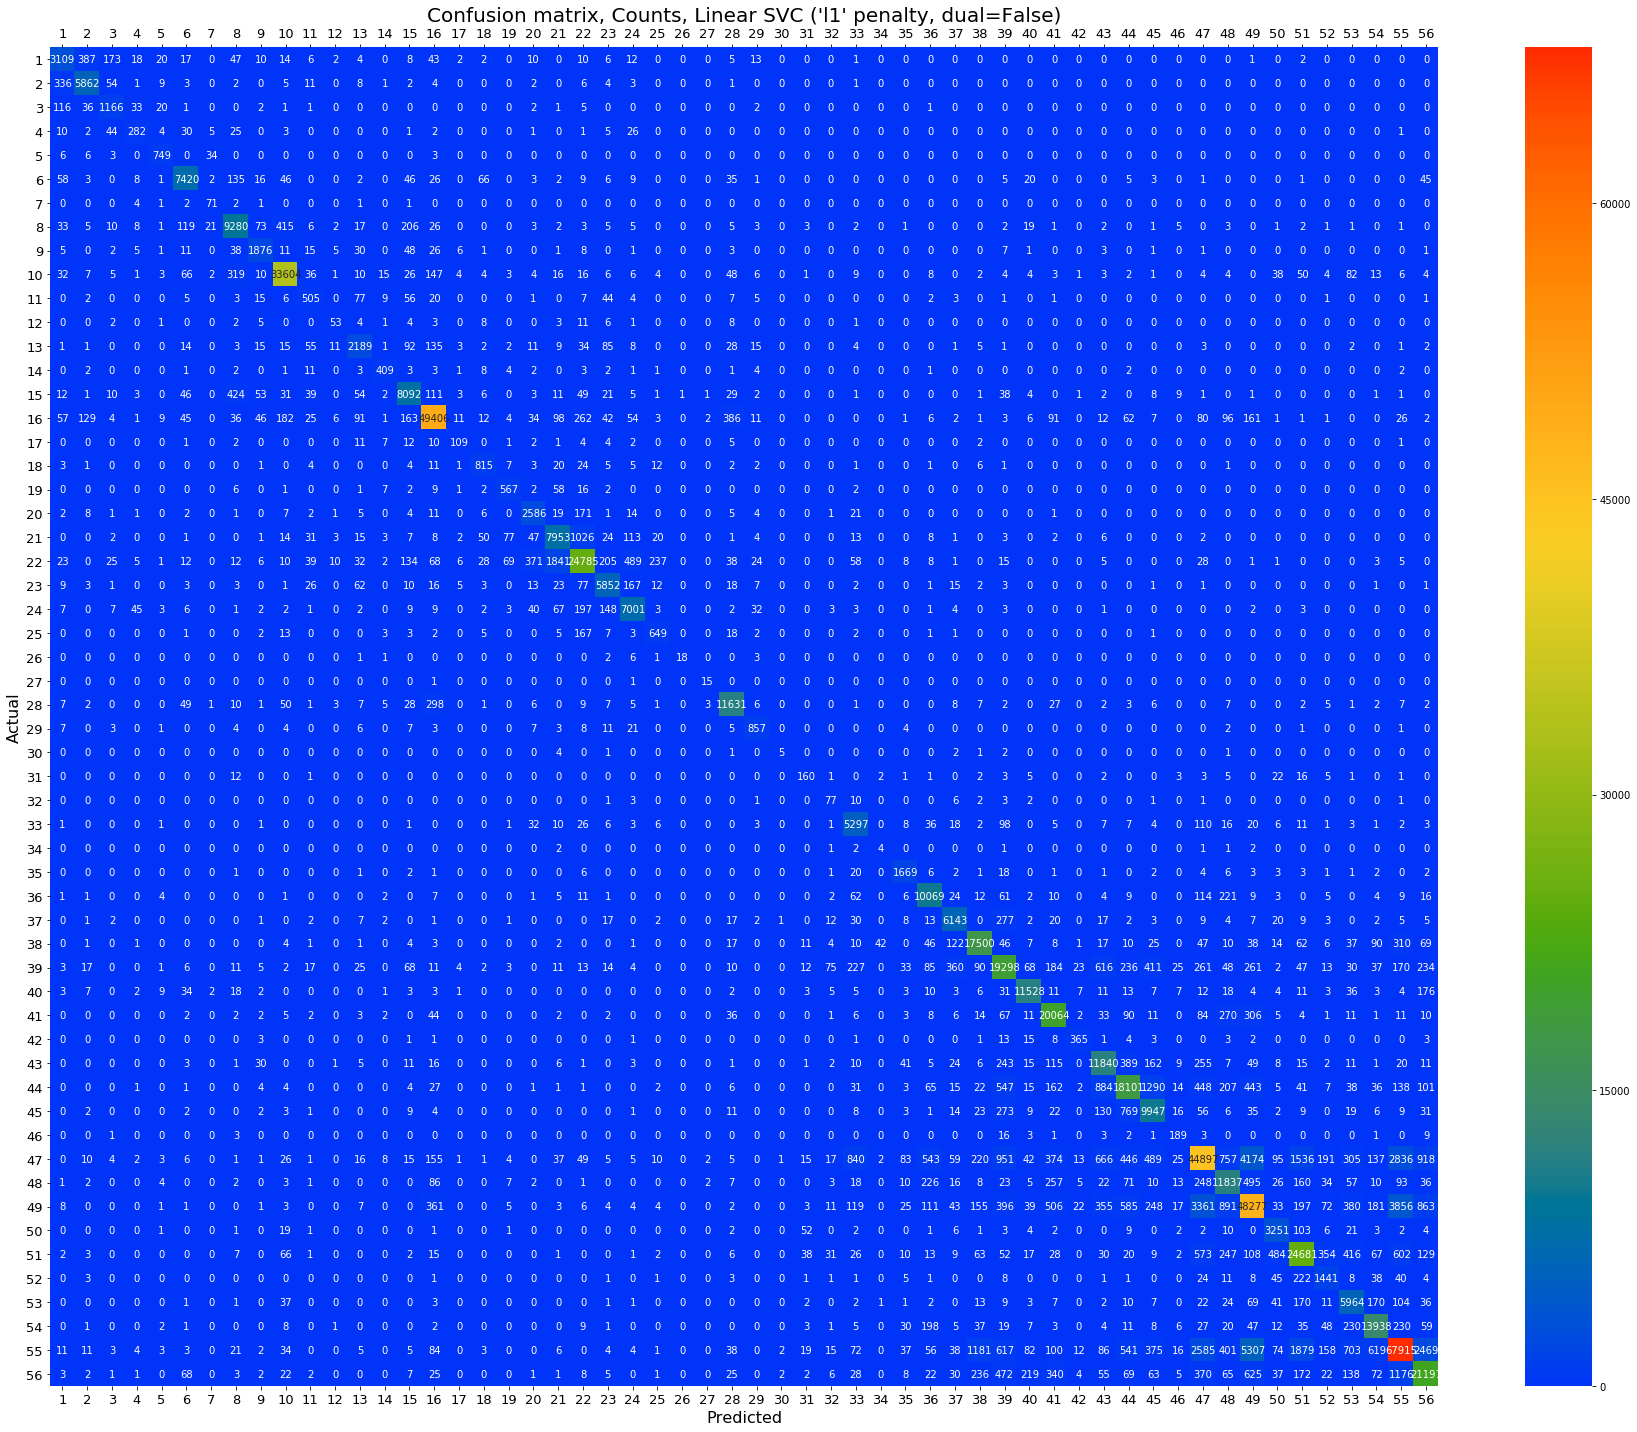

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(25, 25))
ph.plotConfusionMatrix(confusionMat, saveAs='pdf', xlabels=FDAcodes,
                       ylabels=FDAcodes, titleText = "Linear SVC ('l1' penalty, dual=False)",
                       ax = ax,  xlabelFontSz=labelFontSz,
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

##### Plot recall confusion matrix (normalized by row)

* diagonal elements now represent the *recall* for each class

Δt: 11.59s.


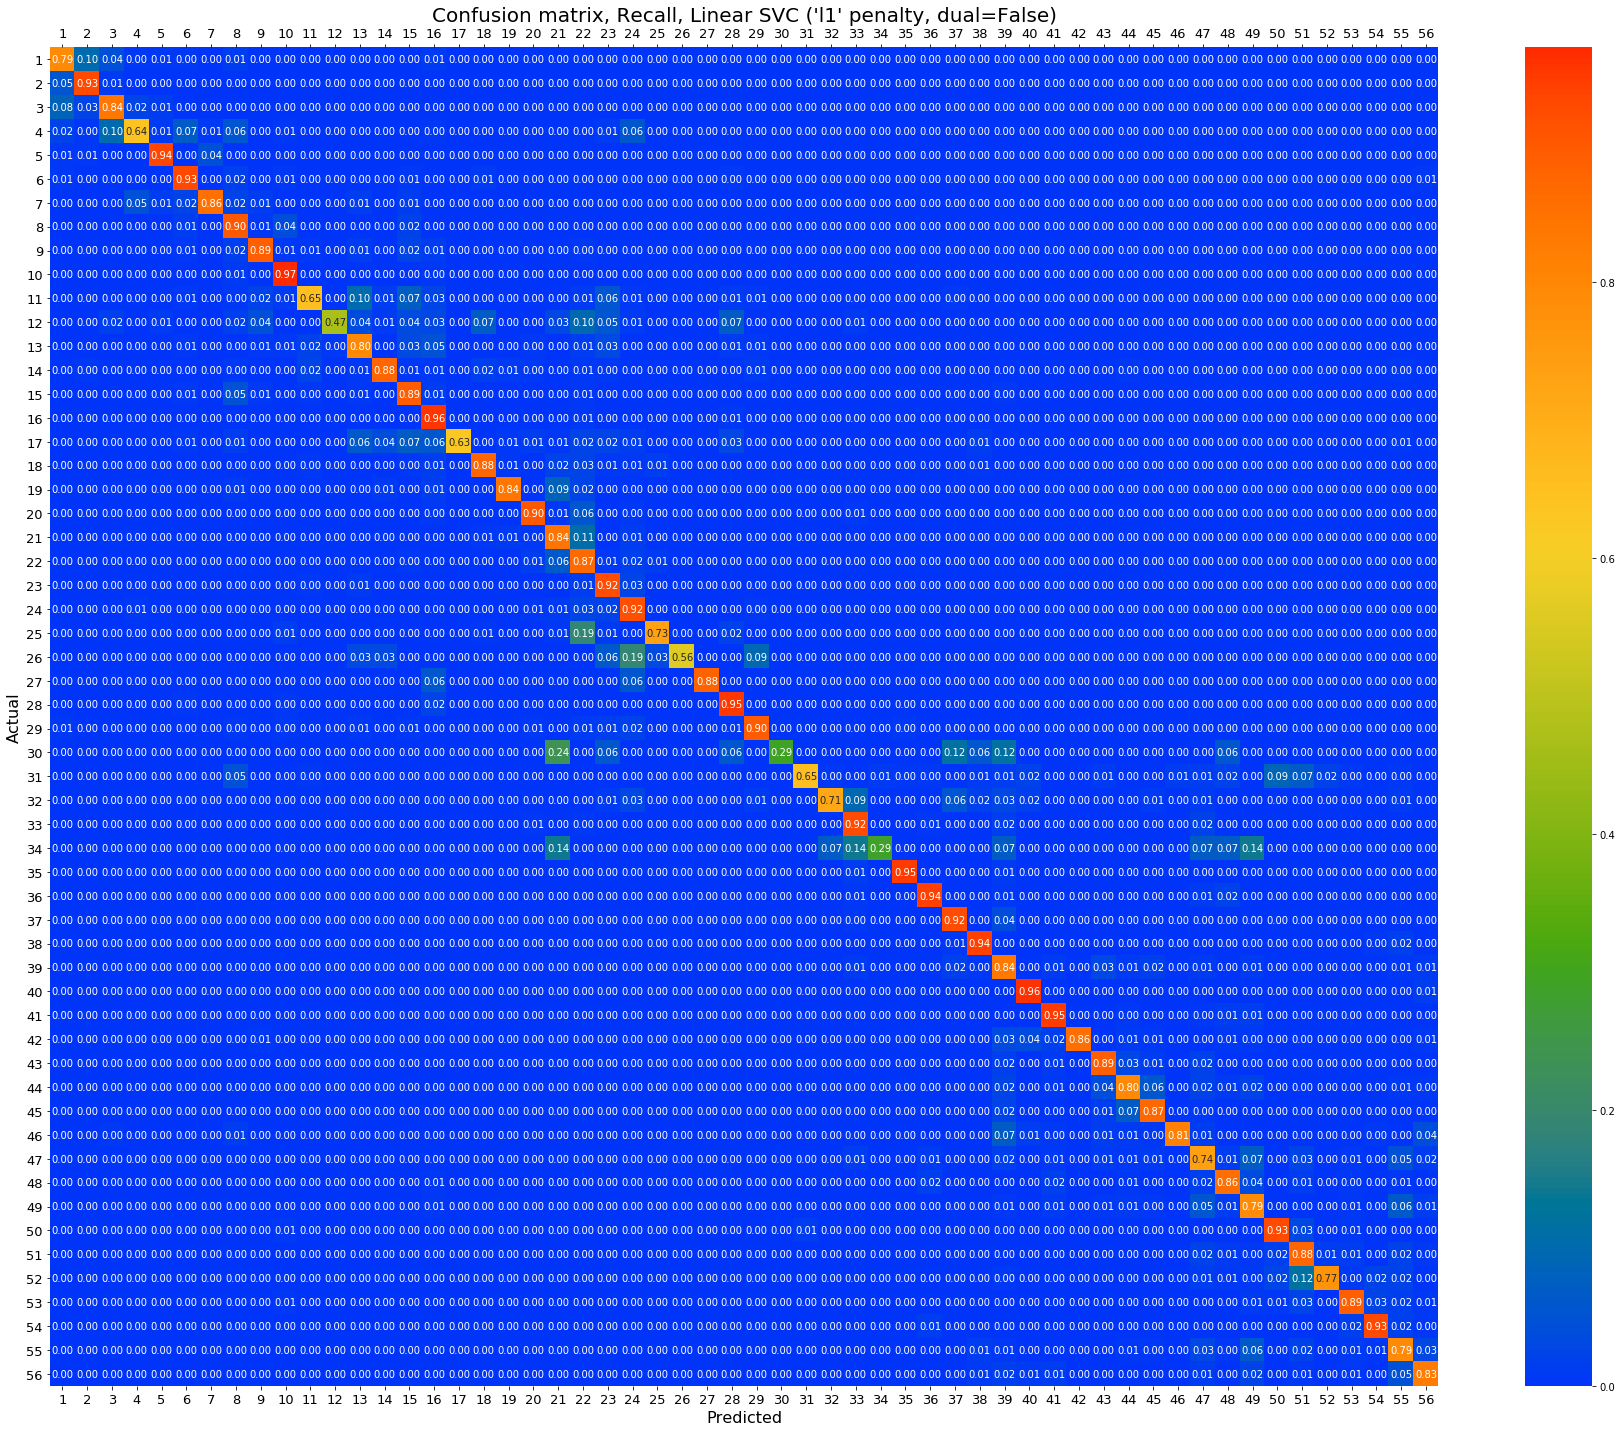

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(25, 25))
ph.plotConfusionMatrix(confusionMat, saveAs='pdf', xlabels=FDAcodes, type='recall',
                       ylabels=FDAcodes, titleText = "Linear SVC ('l1' penalty, dual=False)",
                       ax = ax,  xlabelFontSz=labelFontSz,
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

##### Plot precision confusion matrix (normalized by column)

* diagonal elements now represent the *precision* for each class

Δt: 13.06s.


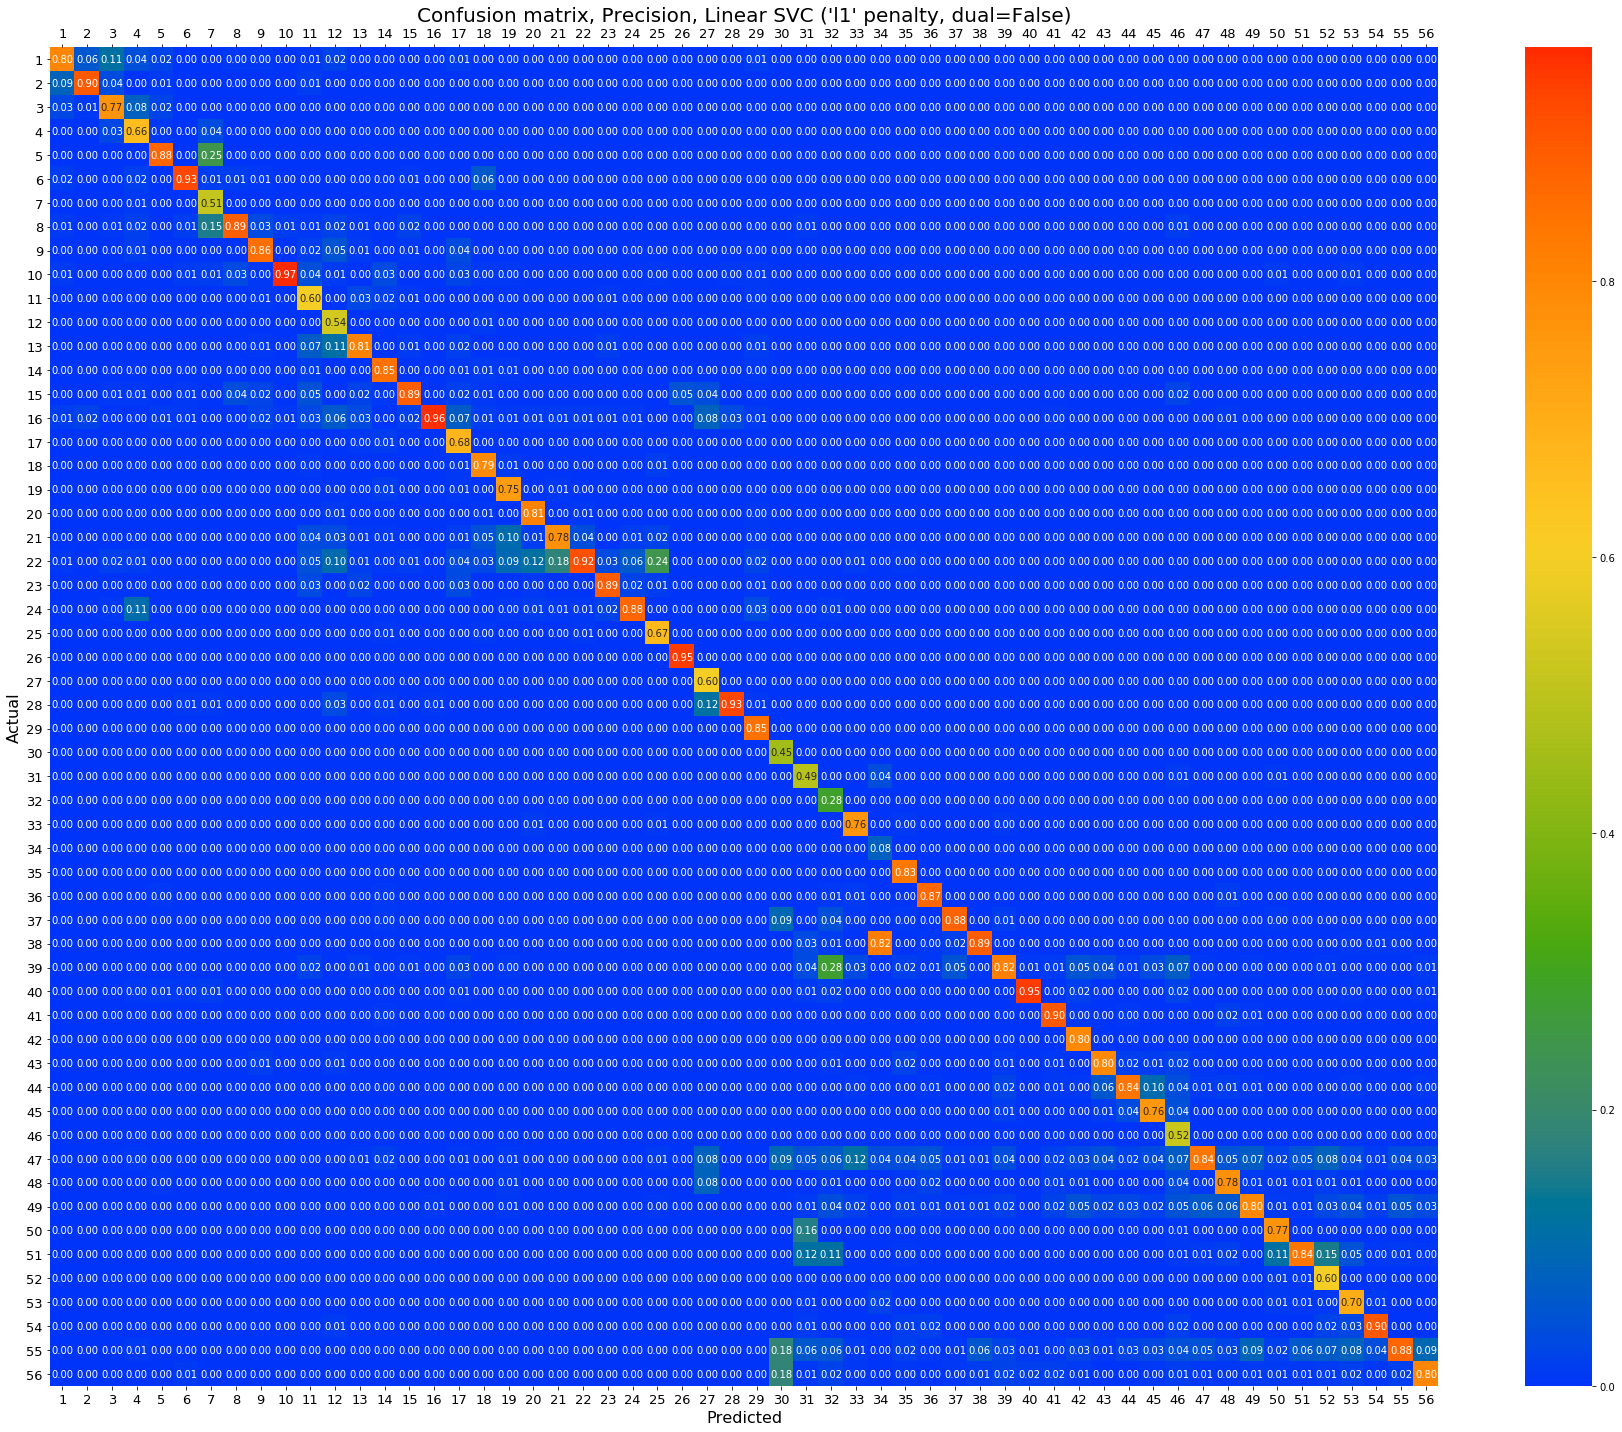

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(25, 25))
ph.plotConfusionMatrix(confusionMat, saveAs='pdf', xlabels=FDAcodes, type='precision',
                       ylabels=FDAcodes, titleText = "Linear SVC ('l1' penalty, dual=False)",
                       ax = ax,  xlabelFontSz=labelFontSz,
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

In [81]:
del LSVC

#### Do some garbage collection before building RF models

In [82]:
for i in range(2):
    print('\nCollecting {} ...'.format(i))
    n = gc.collect()
    print('Unreachable objects:', n)
    print('Remaining Garbage:', end=' ')
    pprint.pprint(gc.garbage)


Unreachable objects: 40
Remaining Garbage: []

Unreachable objects: 0
Remaining Garbage: []


### Complement Naive Bayes

#### TF-IDF with `FDAISCRITICAL`

* default hyperparameters, except `fit_prior=False`, as we have enforced train clasess with ≥ 14 elements
* For np.shape(Xtr) = (560000, 178558), fit takes ~ min.

In [83]:
np.shape(Xtrp), np.shape(yTr), np.shape(Xtep), np.shape(yTe)

((653979, 196227), (653979,), (654005, 196227), (654005,))

In [84]:
print(asctime(gmtime()))
CNBname = 'ComplementNaiveBayes0.joblib'

if os.path.isfile(CNBname):
    CNB = load(CNBname)
    t1 = time()
else:
    CNB = ComplementNB(fit_prior=False)
    t0 = time()
    CNB.fit(Xtrp, yTr)
    t1 = time()
    Δt01 = t1 - t0
    print("Δt01: {0} m, {1:4.1f} s.".format(int(Δt01//60), Δt01 % 60.0))

yPred = CNB.predict(Xtep)
t2 = time()
Δt = t2 - t1
print(f"\n\nΔt: {int(Δt//60)}m, {Δt % 60.0:4.1f}s.")

Mon Aug 19 09:20:48 2019


ComplementNB(alpha=1.0, class_prior=None, fit_prior=False, norm=False)

Δt01: 0 m,  3.9 s.


Δt: 0m,  2.2s.


In [85]:
print(yTe[:20].values)
print(yPred[:20])

[50 22 51 22 49 16 28 44 51 16 45 55 55 16 48 21 38 33 38 55]
[50 22 51 22 16 16 28 39 51 16 39 55 55 16 48 21 38 33 38 49]


**Save model to disk**

In [86]:
if not os.path.isfile(CNBname):
    dump(CNB, CNBname)

['ComplementNaiveBayes0.joblib']

#### Overall accuracy, precision, recall

In [87]:
confusionMat = confusion_matrix(yTe, yPred)
print(confusionMat)

[[ 2280   656   295 ...     1    22     5]
 [  235  5939    39 ...     0     3     2]
 [   80    70  1152 ...     0     0     0]
 ...
 [    5     1     0 ... 13510   404    50]
 [   10    30     1 ...   500 71128  1790]
 [    5    14     0 ...    83  2031 19781]]


In [88]:
accuracy = np.trace(confusionMat)/np.sum(confusionMat)
recall = np.diag(confusionMat)/np.sum(confusionMat, axis=1)
precision = np.diag(confusionMat)/np.sum(confusionMat, axis=0)
print(f"accuracy: {accuracy:0.3f}, "
      f"<precision>: {np.mean(precision):0.3f}, "
      f"<recall>: {np.mean(recall):0.3f}")

accuracy: 0.794, <precision>: nan, <recall>: 0.603


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


##### Recall, precision by class

In [89]:
print(metrics.classification_report(yTe.values, yPred, target_names=[str(c)for c in FDAcodes]))

/home/wilber/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           1       0.84      0.58      0.69      3922
           2       0.84      0.94      0.89      6315
           3       0.68      0.83      0.75      1387
           4       0.76      0.12      0.20       442
           5       0.85      0.96      0.90       801
           6       0.79      0.87      0.83      7974
           7       0.33      0.01      0.02        83
           8       0.76      0.88      0.82     10293
           9       0.85      0.72      0.78      2107
          10       0.80      0.95      0.87     34644
          11       0.73      0.23      0.35       775
          12       1.00      0.07      0.13       113
          13       0.80      0.63      0.71      2748
          14       0.82      0.80      0.81       467
          15       0.77      0.72      0.75      9078
          16       0.76      0.77      0.77     51679
          17       0.66      0.16      0.25       174
          18       0.85    

In [90]:
classCts = dfTe['fda_q_fixed'].value_counts()

recall = np.diag(confusionMat)/np.sum(confusionMat, axis = 1)
precision = np.diag(confusionMat)/np.sum(confusionMat, axis = 0)
f1 = 2.0*precision*recall/(precision + recall)
print("class\tprecision\trecall\tf1\tsize")

for FDAcode, classCt in classCts.iteritems():
    print(f"{FDAcode}\t{precision[FDAcode - 1]:0.3f}\t\t{recall[FDAcode - 1]:0.3f}\t{f1[FDAcode - 1]:0.3f}\t\t{classCt:d}")

class	precision	recall	f1	size
55	0.813		0.831	0.822		85601
49	0.711		0.718	0.715		61156
47	0.808		0.705	0.753		60999
16	0.765		0.773	0.769		51679
10	0.796		0.951	0.867		34644
22	0.685		0.931	0.789		28605
51	0.801		0.850	0.825		28115
56	0.808		0.772	0.790		25612
39	0.804		0.719	0.759		23073
44	0.834		0.747	0.788		22667
41	0.809		0.895	0.850		21121
38	0.888		0.923	0.905		18567
54	0.885		0.900	0.893		15008
48	0.838		0.663	0.740		13801
43	0.756		0.853	0.801		13319
28	0.893		0.823	0.857		12213
40	0.897		0.895	0.896		12008
45	0.738		0.801	0.768		11423
36	0.855		0.924	0.888		10676
8	0.757		0.884	0.815		10293
21	0.767		0.601	0.674		9437
15	0.774		0.721	0.746		9078
6	0.789		0.865	0.826		7974
24	0.834		0.872	0.852		7609
53	0.823		0.579	0.679		6714
37	0.844		0.846	0.845		6647
23	0.832		0.867	0.849		6338
2	0.836		0.940	0.885		6315
33	0.781		0.591	0.673		5747
1	0.836		0.581	0.686		3922
50	0.823		0.477	0.604		3510
20	0.823		0.333	0.474		2874
13	0.802		0.635	0.709		2748
9	0.846		0.716	0.776		2107
52

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


##### Plot confusion matrix

* As this is a straight confusion matrix, diagonal elements mostly reflect class size in test set
* *This is hard to interpret by visual inspection alone*

In [91]:
labelFontSz = 16
tickFontSz = 13
titleFontSz = 20

Δt: 10.82s.


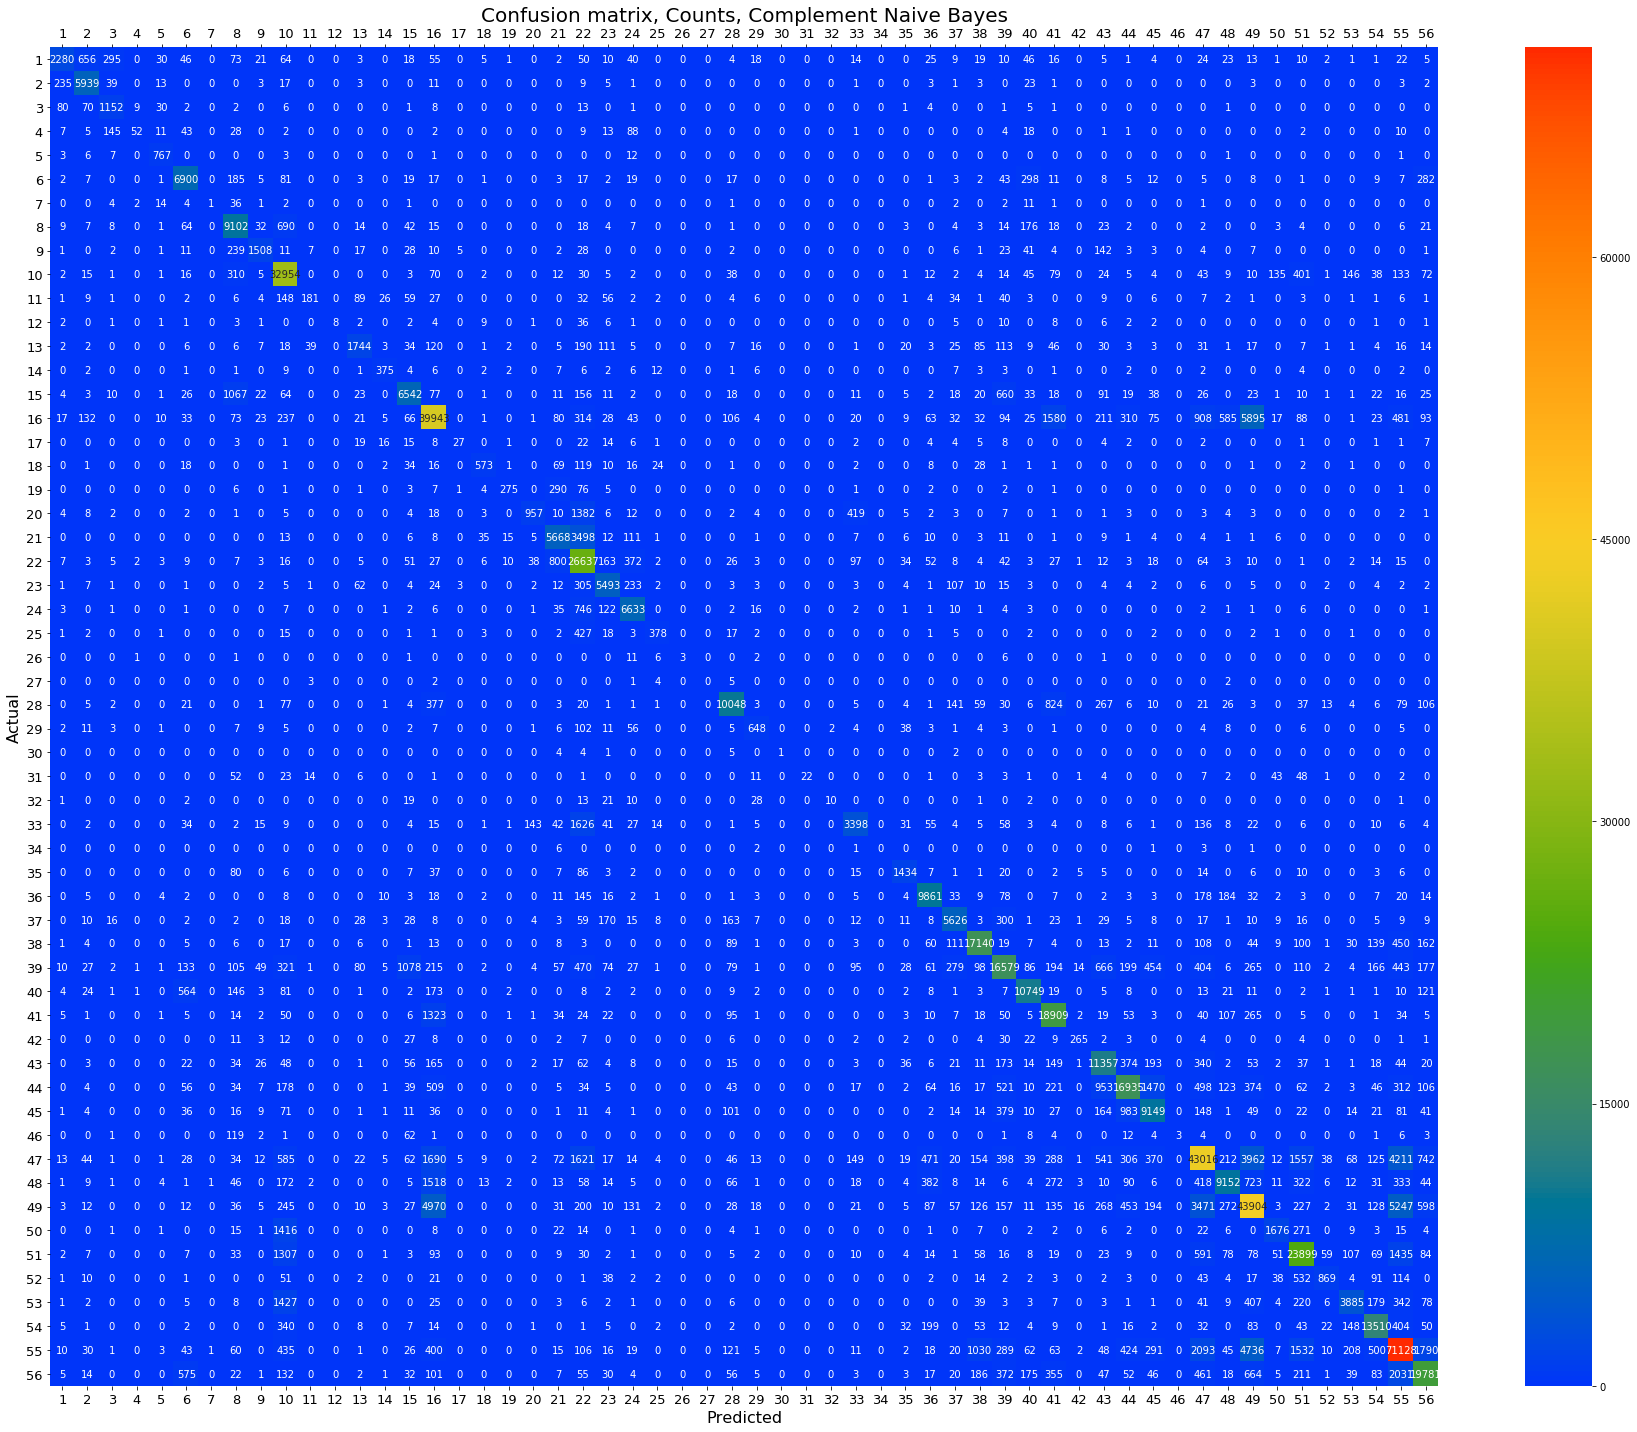

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(25, 25))
ph.plotConfusionMatrix(confusionMat, saveAs='pdf', xlabels=FDAcodes,
                       ylabels=FDAcodes, titleText = 'Complement Naive Bayes',
                       ax = ax,  xlabelFontSz=labelFontSz,
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

##### Plot recall confusion matrix (normalized by row)

* diagonal elements now represent the *recall* for each class

Δt: 11.69s.


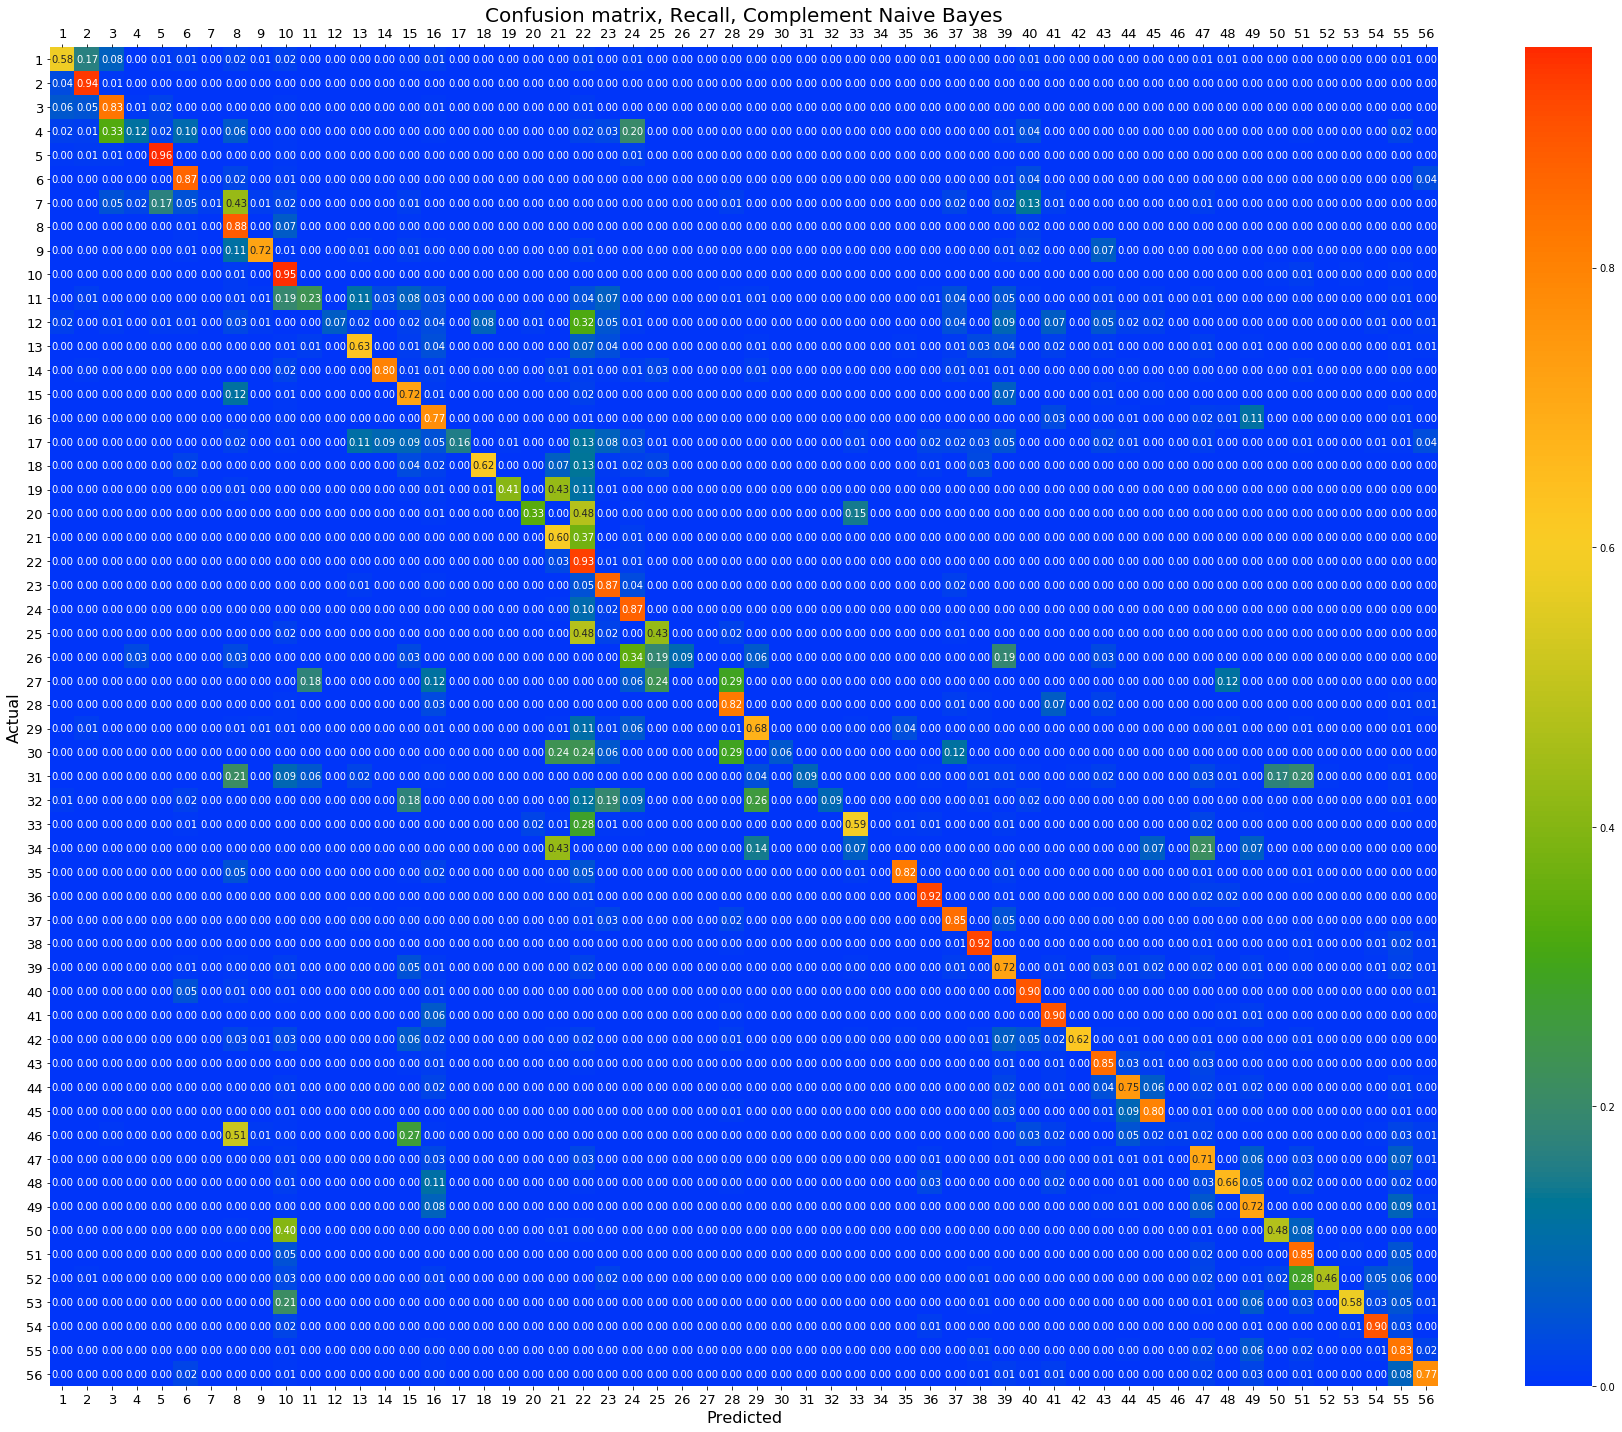

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(25, 25))
ph.plotConfusionMatrix(confusionMat, saveAs='pdf', xlabels=FDAcodes, type='recall',
                       ylabels=FDAcodes, titleText = 'Complement Naive Bayes',
                       ax = ax,  xlabelFontSz=labelFontSz,
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

##### Plot precision confusion matrix (normalized by column)

* diagonal elements now represent the *precision* for each class

/home/wilber/work/Mlib/plotHelpers/plotHelpers.py:90: RuntimeWarning: invalid value encountered in true_divide
  confusionMat.sum(axis=0)[np.newaxis, :])


Δt: 12.63s.


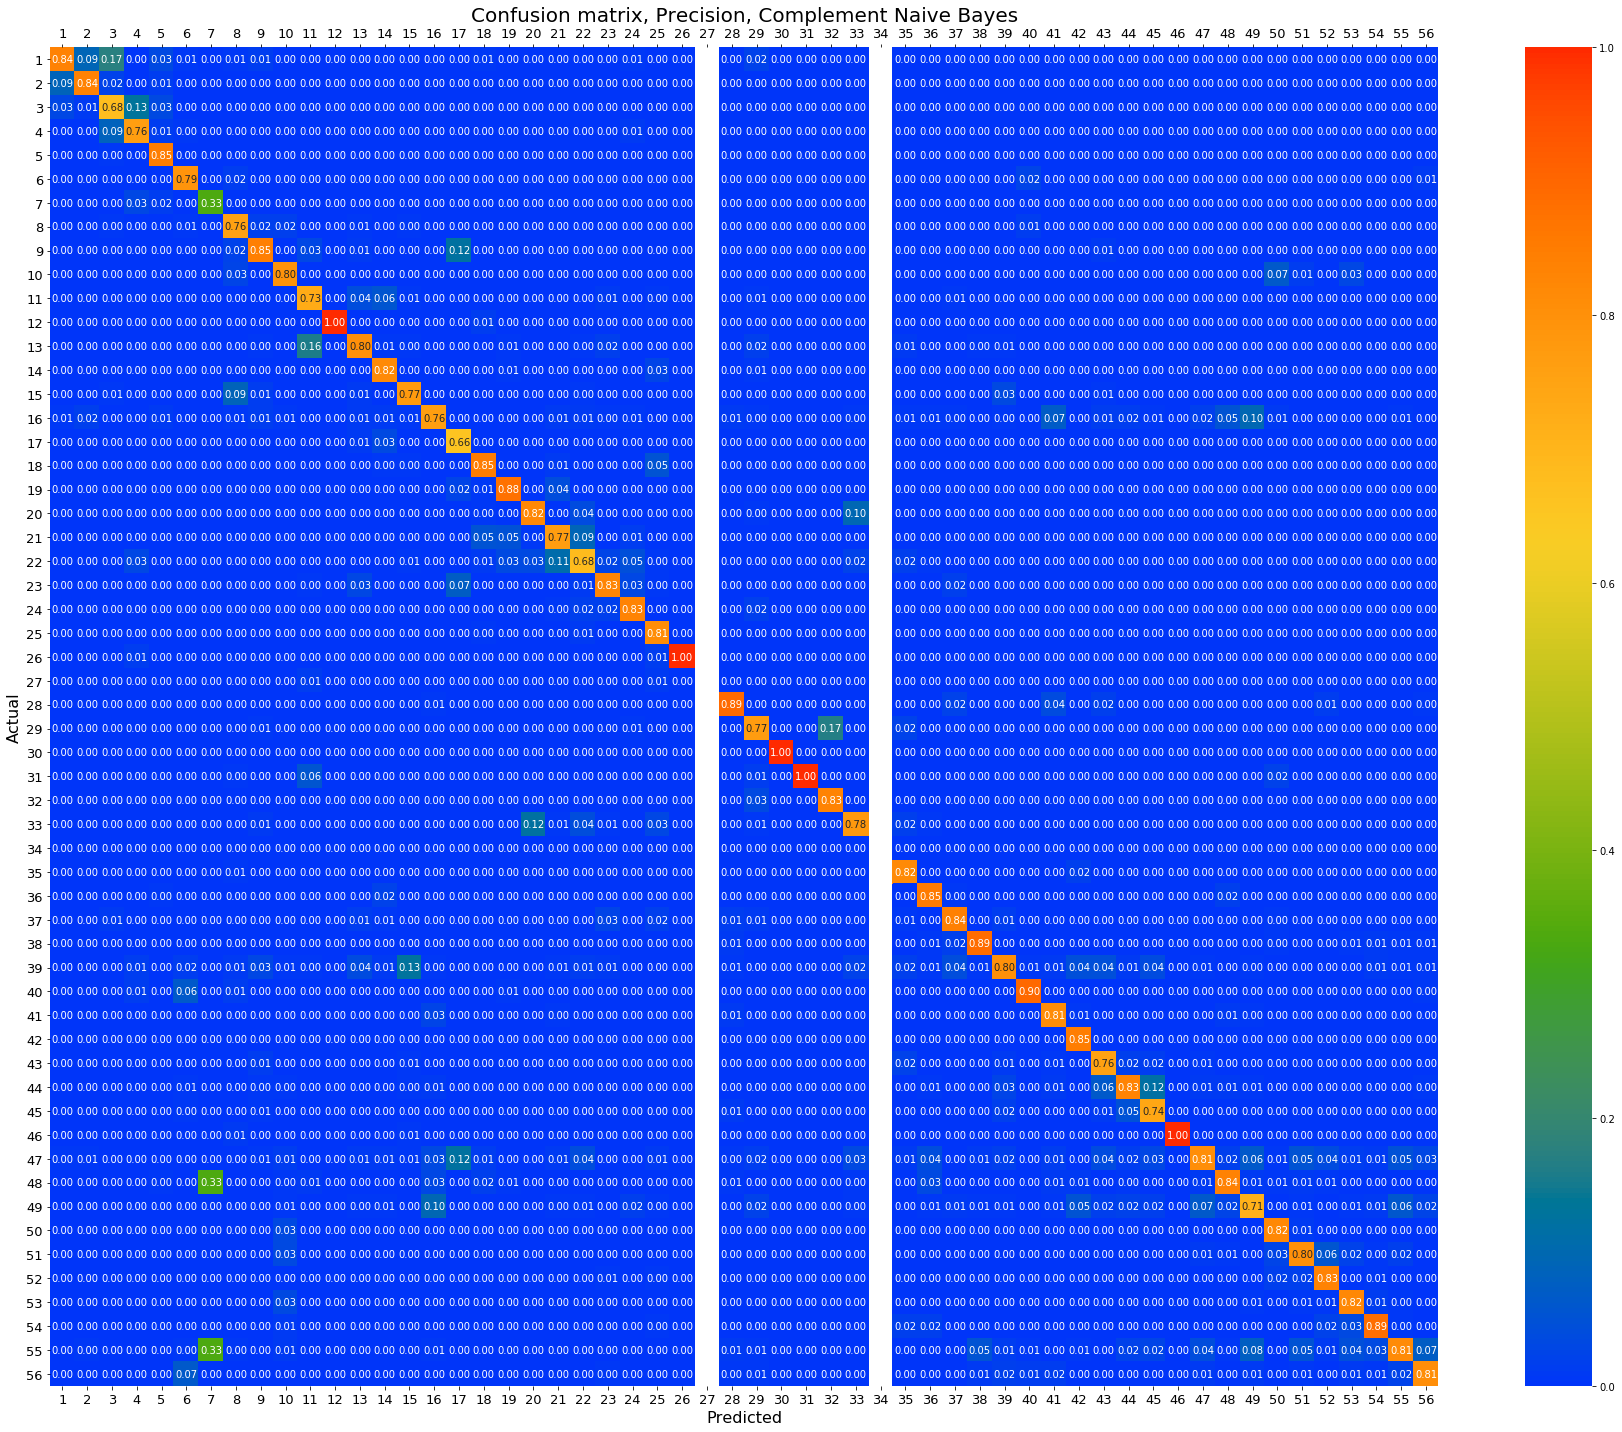

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(25, 25))
ph.plotConfusionMatrix(confusionMat, saveAs='pdf', xlabels=FDAcodes, type='precision',
                       ylabels=FDAcodes, titleText = 'Complement Naive Bayes',
                       ax = ax,  xlabelFontSz=labelFontSz,
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)